In [38]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Deep Learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

All libraries imported successfully!
TensorFlow version: 2.19.0
NumPy version: 2.0.2
Pandas version: 2.2.2


In [39]:
# Kaggle paths
BASE_DIR = "/kaggle/working"
DATA_PATH = f"{BASE_DIR}/data"
MODELS_PATH = f"{BASE_DIR}/models"
OUTPUTS_PATH = f"{BASE_DIR}/outputs"

# Create directories
for path in [DATA_PATH, MODELS_PATH, OUTPUTS_PATH]:
    os.makedirs(path, exist_ok=True)

print("Project directories created in Kaggle")
print(f"Data directory: {DATA_PATH}")
print(f"Models directory: {MODELS_PATH}")
print(f"Outputs directory: {OUTPUTS_PATH}")

# Competition input path (CHANGE competition name if needed)
COMPETITION_PATH = "/kaggle/input/formative-1-time-series-forecasting-january-2026"

train_path = f"{COMPETITION_PATH}/train.csv"
test_path = f"{COMPETITION_PATH}/test.csv"
sample_path = f"{COMPETITION_PATH}/sample_submission.csv"

print("\nFile existence check:")
print(f"train.csv exists: {os.path.exists(train_path)}")
print(f"test.csv exists: {os.path.exists(test_path)}")
print(f"sample_submission.csv exists: {os.path.exists(sample_path)}")

Project directories created in Kaggle
Data directory: /kaggle/working/data
Models directory: /kaggle/working/models
Outputs directory: /kaggle/working/outputs

File existence check:
train.csv exists: True
test.csv exists: True
sample_submission.csv exists: False


In [40]:
# Load the datasets with proper error handling
try:
    train = pd.read_csv(os.path.join(train_path))
    test = pd.read_csv(os.path.join(test_path))
    
    print("All datasets loaded successfully!")
    print(f"Training data shape: {train.shape}")
    print(f"Test data shape: {test.shape}")
    
except FileNotFoundError as e:
    print("Error: Data files not found!")
    print("Please download the following files from Kaggle and place them in the data folder:")
    print("- train.csv")
    print("- test.csv") 
    print("- sample_submission.csv")
    print(f"\nData folder path: {DATA_PATH}")
    raise e

# Display basic information about the datasets
print("\n" + "="*60)
print("DATASET OVERVIEW")
print("="*60)

All datasets loaded successfully!
Training data shape: (30676, 12)
Test data shape: (13148, 11)

DATASET OVERVIEW


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [41]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [42]:
# Comprehensive data structure analysis
print("TRAINING DATA COLUMNS AND TYPES:")
print("-" * 40)
for i, (col, dtype) in enumerate(zip(train.columns, train.dtypes)):
    print(f"{i+1:2d}. {col:<12} - {dtype}")

print(f"\nTRAINING DATA FEATURES:")
print(f"- Total columns: {len(train.columns)}")
print(f"- Numerical features: {len(train.select_dtypes(include=[np.number]).columns)}")
print(f"- Categorical features: {len(train.select_dtypes(include=[object]).columns)}")
print(f"- Target variable: pm2.5")

print(f"\nColumn descriptions based on typical air quality datasets:")
feature_descriptions = {
    'No': 'Row number/index',
    'DEWP': 'Dew Point temperature (°C)',
    'TEMP': 'Temperature (°C)',
    'PRES': 'Atmospheric pressure (hPa)',
    'Iws': 'Cumulated wind speed (m/s)',
    'Is': 'Cumulated precipitation (mm)',
    'Ir': 'Cumulated rainfall (mm)',
    'datetime': 'Date and time',
    'cbwd_NW': 'Wind direction - Northwest (binary)',
    'cbwd_SE': 'Wind direction - Southeast (binary)',
    'cbwd_cv': 'Wind direction - Variable (binary)',
    'pm2.5': 'PM2.5 concentration (µg/m³) - TARGET'
}

for col, desc in feature_descriptions.items():
    if col in train.columns:
        print(f"- {col}: {desc}")

TRAINING DATA COLUMNS AND TYPES:
----------------------------------------
 1. No           - int64
 2. DEWP         - float64
 3. TEMP         - float64
 4. PRES         - float64
 5. Iws          - float64
 6. Is           - float64
 7. Ir           - float64
 8. datetime     - object
 9. cbwd_NW      - float64
10. cbwd_SE      - float64
11. cbwd_cv      - float64
12. pm2.5        - float64

TRAINING DATA FEATURES:
- Total columns: 12
- Numerical features: 11
- Categorical features: 1
- Target variable: pm2.5

Column descriptions based on typical air quality datasets:
- No: Row number/index
- DEWP: Dew Point temperature (°C)
- TEMP: Temperature (°C)
- PRES: Atmospheric pressure (hPa)
- Iws: Cumulated wind speed (m/s)
- Is: Cumulated precipitation (mm)
- Ir: Cumulated rainfall (mm)
- datetime: Date and time
- cbwd_NW: Wind direction - Northwest (binary)
- cbwd_SE: Wind direction - Southeast (binary)
- cbwd_cv: Wind direction - Variable (binary)
- pm2.5: PM2.5 concentration (µg/m³) - TA

In [43]:
# Statistical summary of the training data
print("\n" + "="*60)
print("STATISTICAL SUMMARY")
print("="*60)

# Basic statistics
print("\nBasic Statistics for Numerical Features:")
numerical_features = train.select_dtypes(include=[np.number]).columns
print(train[numerical_features].describe().round(2))

# Missing values analysis
print("\nMissing Values Analysis:")
missing_data = train.isnull().sum()
missing_percent = (missing_data / len(train)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percent
}).sort_values('Missing Count', ascending=False)

print(missing_df[missing_df['Missing Count'] > 0])

if missing_df['Missing Count'].sum() == 0:
    print("No missing values found in the training dataset!")
else:
    print(f"Total missing values: {missing_df['Missing Count'].sum()}")
    print(f"Features with missing data: {len(missing_df[missing_df['Missing Count'] > 0])}")

# Target variable analysis
print(f"\nTARGET VARIABLE (PM2.5) ANALYSIS:")
print(f"- Mean: {train['pm2.5'].mean():.2f} µg/m³")
print(f"- Median: {train['pm2.5'].median():.2f} µg/m³")
print(f"- Standard deviation: {train['pm2.5'].std():.2f} µg/m³")
print(f"- Min: {train['pm2.5'].min():.2f} µg/m³")
print(f"- Max: {train['pm2.5'].max():.2f} µg/m³")
print(f"- Range: {train['pm2.5'].max() - train['pm2.5'].min():.2f} µg/m³")

# PM2.5 health standards context
print(f"\nHEALTH CONTEXT (WHO Air Quality Guidelines):")
print(f"- WHO 24-hour mean guideline: 15 µg/m³")
print(f"- Data points exceeding WHO guideline: {(train['pm2.5'] > 15).sum()} ({(train['pm2.5'] > 15).mean()*100:.1f}%)")
print(f"- Very high pollution (>150 µg/m³): {(train['pm2.5'] > 150).sum()} ({(train['pm2.5'] > 150).mean()*100:.1f}%)")


STATISTICAL SUMMARY

Basic Statistics for Numerical Features:
             No      DEWP      TEMP      PRES       Iws        Is        Ir  \
count  30676.00  30676.00  30676.00  30676.00  30676.00  30676.00  30676.00   
mean   15338.50     -0.03     -0.06      0.01      0.03      0.02      0.01   
std     8855.54      0.99      1.02      1.01      1.02      1.09      1.06   
min        1.00     -2.14     -2.58     -2.38     -0.47     -0.07     -0.14   
25%     7669.75     -0.89     -0.94     -0.82     -0.44     -0.07     -0.14   
50%    15338.50     -0.06      0.05     -0.04     -0.35     -0.07     -0.14   
75%    23007.25      0.91      0.86      0.83      0.01     -0.07     -0.14   
max    30676.00      1.81      2.34      2.88     11.23     35.44     25.29   

        cbwd_NW   cbwd_SE   cbwd_cv     pm2.5  
count  30676.00  30676.00  30676.00  28755.00  
mean       0.02      0.01     -0.03    100.79  
std        1.01      1.00      0.98     93.14  
min       -0.69     -0.73     -0.

Creating comprehensive visualizations for data exploration...


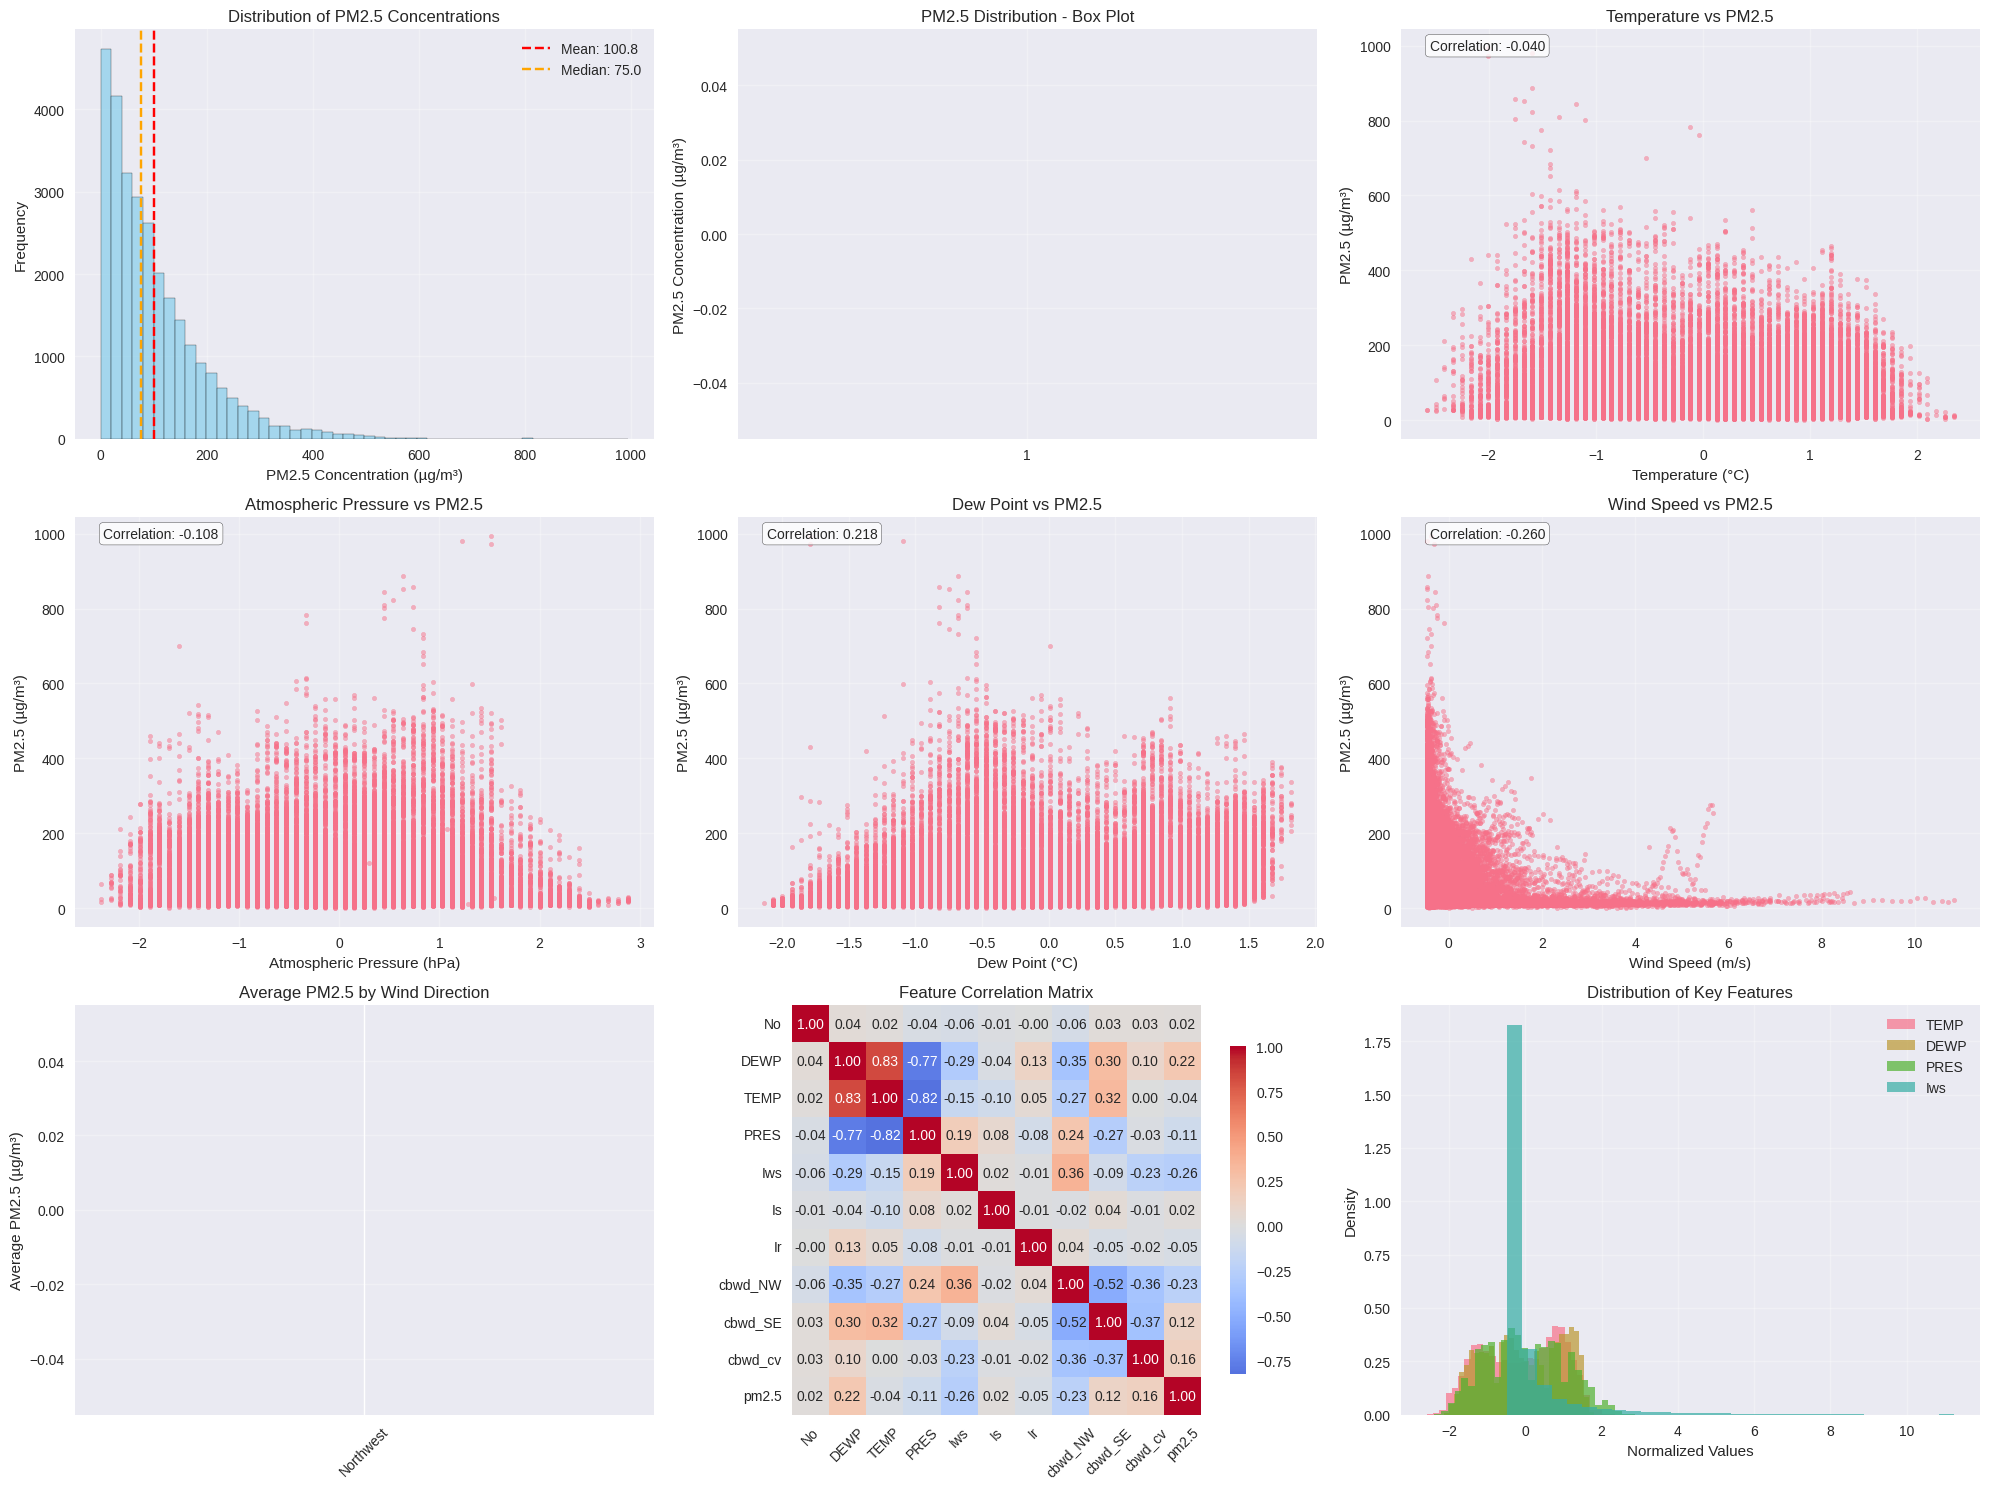

Creating comprehensive visualizations for data exploration...

PM2.5 Distribution: Checks skewness, outliers, and if transformation (e.g., log) is needed.
Box Plot: Highlights extreme outliers that may bias model training.
Temperature vs PM2.5: Shows correlation; non-linear patterns may require feature engineering.
Pressure vs PM2.5: Explores how air pressure affects pollution dispersion.
Dew Point vs PM2.5: Higher humidity often increases PM2.5, useful for prediction.
Wind Speed vs PM2.5: Typically negative correlation; strong dispersal effect.
Wind Direction: Certain directions bring more pollution, requires categorical encoding.
Correlation Matrix: Identifies redundant features and strong predictors of PM2.5.
Feature Distributions: Helps decide scaling/normalization for ML models.

Preprocessing Notes: Handle missing values, treat outliers, scale features, create time-based & interaction features, and encode categorical variables like wind direction.

Comprehensive data exploration 

In [44]:
# Create visualizations for comprehensive data exploration
print("Creating comprehensive visualizations for data exploration...")

# Set up the plotting environment
plt.rcParams['figure.figsize'] = (12, 8)
fig = plt.figure(figsize=(20, 15))

# 1. Target variable distribution
plt.subplot(3, 3, 1)
plt.hist(train['pm2.5'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(train['pm2.5'].mean(), color='red', linestyle='--', label=f'Mean: {train["pm2.5"].mean():.1f}')
plt.axvline(train['pm2.5'].median(), color='orange', linestyle='--', label=f'Median: {train["pm2.5"].median():.1f}')
plt.xlabel('PM2.5 Concentration (µg/m³)')
plt.ylabel('Frequency')
plt.title('Distribution of PM2.5 Concentrations')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. PM2.5 Box plot (to identify outliers)
plt.subplot(3, 3, 2)
plt.boxplot(train['pm2.5'], vert=True, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', alpha=0.7))
plt.ylabel('PM2.5 Concentration (µg/m³)')
plt.title('PM2.5 Distribution - Box Plot')
plt.grid(True, alpha=0.3)

# 3. Temperature vs PM2.5
plt.subplot(3, 3, 3)
plt.scatter(train['TEMP'], train['pm2.5'], alpha=0.5, s=10)
plt.xlabel('Temperature (°C)')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('Temperature vs PM2.5')
correlation = train['TEMP'].corr(train['pm2.5'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
plt.grid(True, alpha=0.3)

# 4. Pressure vs PM2.5
plt.subplot(3, 3, 4)
plt.scatter(train['PRES'], train['pm2.5'], alpha=0.5, s=10)
plt.xlabel('Atmospheric Pressure (hPa)')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('Atmospheric Pressure vs PM2.5')
correlation = train['PRES'].corr(train['pm2.5'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
plt.grid(True, alpha=0.3)

# 5. Dew Point vs PM2.5
plt.subplot(3, 3, 5)
plt.scatter(train['DEWP'], train['pm2.5'], alpha=0.5, s=10)
plt.xlabel('Dew Point (°C)')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('Dew Point vs PM2.5')
correlation = train['DEWP'].corr(train['pm2.5'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
plt.grid(True, alpha=0.3)

# 6. Wind Speed vs PM2.5
plt.subplot(3, 3, 6)
plt.scatter(train['Iws'], train['pm2.5'], alpha=0.5, s=10)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('Wind Speed vs PM2.5')
correlation = train['Iws'].corr(train['pm2.5'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
plt.grid(True, alpha=0.3)

# 7. Wind direction analysis
plt.subplot(3, 3, 7)
wind_directions = ['cbwd_NW', 'cbwd_SE', 'cbwd_cv']
wind_data = []
wind_labels = ['Northwest', 'Southeast', 'Variable']

for col, label in zip(wind_directions, wind_labels):
    if col in train.columns:
        wind_data.append(train[train[col] == 1]['pm2.5'].mean())
    else:
        wind_data.append(0)

plt.bar(wind_labels, wind_data, color=['blue', 'green', 'orange'], alpha=0.7)
plt.ylabel('Average PM2.5 (µg/m³)')
plt.title('Average PM2.5 by Wind Direction')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# 8. Correlation heatmap
plt.subplot(3, 3, 8)
# Select numerical columns for correlation
numeric_cols = train.select_dtypes(include=[np.number]).columns
correlation_matrix = train[numeric_cols].corr()

# Create heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# 9. Feature distributions
plt.subplot(3, 3, 9)
features_to_plot = ['TEMP', 'DEWP', 'PRES', 'Iws']
for i, feature in enumerate(features_to_plot):
    plt.hist(train[feature], bins=30, alpha=0.7, label=feature, density=True)
plt.xlabel('Normalized Values')
plt.ylabel('Density')
plt.title('Distribution of Key Features')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_PATH, 'exploratory_data_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()
print("Creating comprehensive visualizations for data exploration...\n")

# 1. Target variable distribution
print("PM2.5 Distribution: Checks skewness, outliers, and if transformation (e.g., log) is needed.")

# 2. PM2.5 Box plot
print("Box Plot: Highlights extreme outliers that may bias model training.")

# 3. Temperature vs PM2.5
print("Temperature vs PM2.5: Shows correlation; non-linear patterns may require feature engineering.")

# 4. Pressure vs PM2.5
print("Pressure vs PM2.5: Explores how air pressure affects pollution dispersion.")

# 5. Dew Point vs PM2.5
print("Dew Point vs PM2.5: Higher humidity often increases PM2.5, useful for prediction.")

# 6. Wind Speed vs PM2.5
print("Wind Speed vs PM2.5: Typically negative correlation; strong dispersal effect.")

# 7. Wind Direction
print("Wind Direction: Certain directions bring more pollution, requires categorical encoding.")

# 8. Correlation heatmap
print("Correlation Matrix: Identifies redundant features and strong predictors of PM2.5.")

# 9. Feature distributions
print("Feature Distributions: Helps decide scaling/normalization for ML models.\n")

print("Preprocessing Notes: Handle missing values, treat outliers, scale features, create time-based & interaction features, and encode categorical variables like wind direction.")

print("\nComprehensive data exploration visualizations created!")

In [45]:
# Enhanced datetime processing and time series analysis
print("Processing datetime and conducting time series analysis...")

# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

# Extract temporal features BEFORE setting as index
print("Extracting temporal features...")
for df, name in [(train, 'train'), (test, 'test')]:
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['week_of_year'] = df['datetime'].dt.isocalendar().week
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    
    # Cyclical encoding for temporal features
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

print("Temporal features extracted successfully!")

# Display temporal data range
print(f"\nTemporal Data Range:")
print(f"Training data: {train['datetime'].min()} to {train['datetime'].max()}")
print(f"Test data: {test['datetime'].min()} to {test['datetime'].max()}")
print(f"Training period duration: {(train['datetime'].max() - train['datetime'].min()).days} days")
print(f"Test period duration: {(test['datetime'].max() - test['datetime'].min()).days} days")
# Display temporal data range
print("\nTemporal Data Range:")
print(f"Training period duration: {(train['datetime'].max() - train['datetime'].min()).days} days")
print(f"Test period duration: {(test['datetime'].max() - test['datetime'].min()).days} days")
print("Data ranges confirm chronological separation between training and testing sets.")

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)
print("Temporal features extracted (cyclical encodings avoid artificial breaks in time).")


print("Datetime set as index for time series analysis!")


Processing datetime and conducting time series analysis...
Extracting temporal features...
Temporal features extracted successfully!

Temporal Data Range:
Training data: 2010-01-01 00:00:00 to 2013-07-02 03:00:00
Test data: 2013-07-02 04:00:00 to 2014-12-31 23:00:00
Training period duration: 1278 days
Test period duration: 547 days

Temporal Data Range:
Training period duration: 1278 days
Test period duration: 547 days
Data ranges confirm chronological separation between training and testing sets.
Temporal features extracted (cyclical encodings avoid artificial breaks in time).
Datetime set as index for time series analysis!



TIME SERIES ANALYSIS
Full Time Series Plot: Shows long-term trends, seasonal cycles, and extreme PM2.5 events. Helps detect periods of unusually high pollution that models must learn to predict.
Detailed First 30 Days: Provides a zoomed-in view of hourly fluctuations, useful for inspecting short-term patterns and potential autocorrelations for time-series modeling.
Rolling Average (7-day): Smooths short-term fluctuations to reveal long-term trends. Useful for models to learn underlying trends and reduce noise impact on predictions.


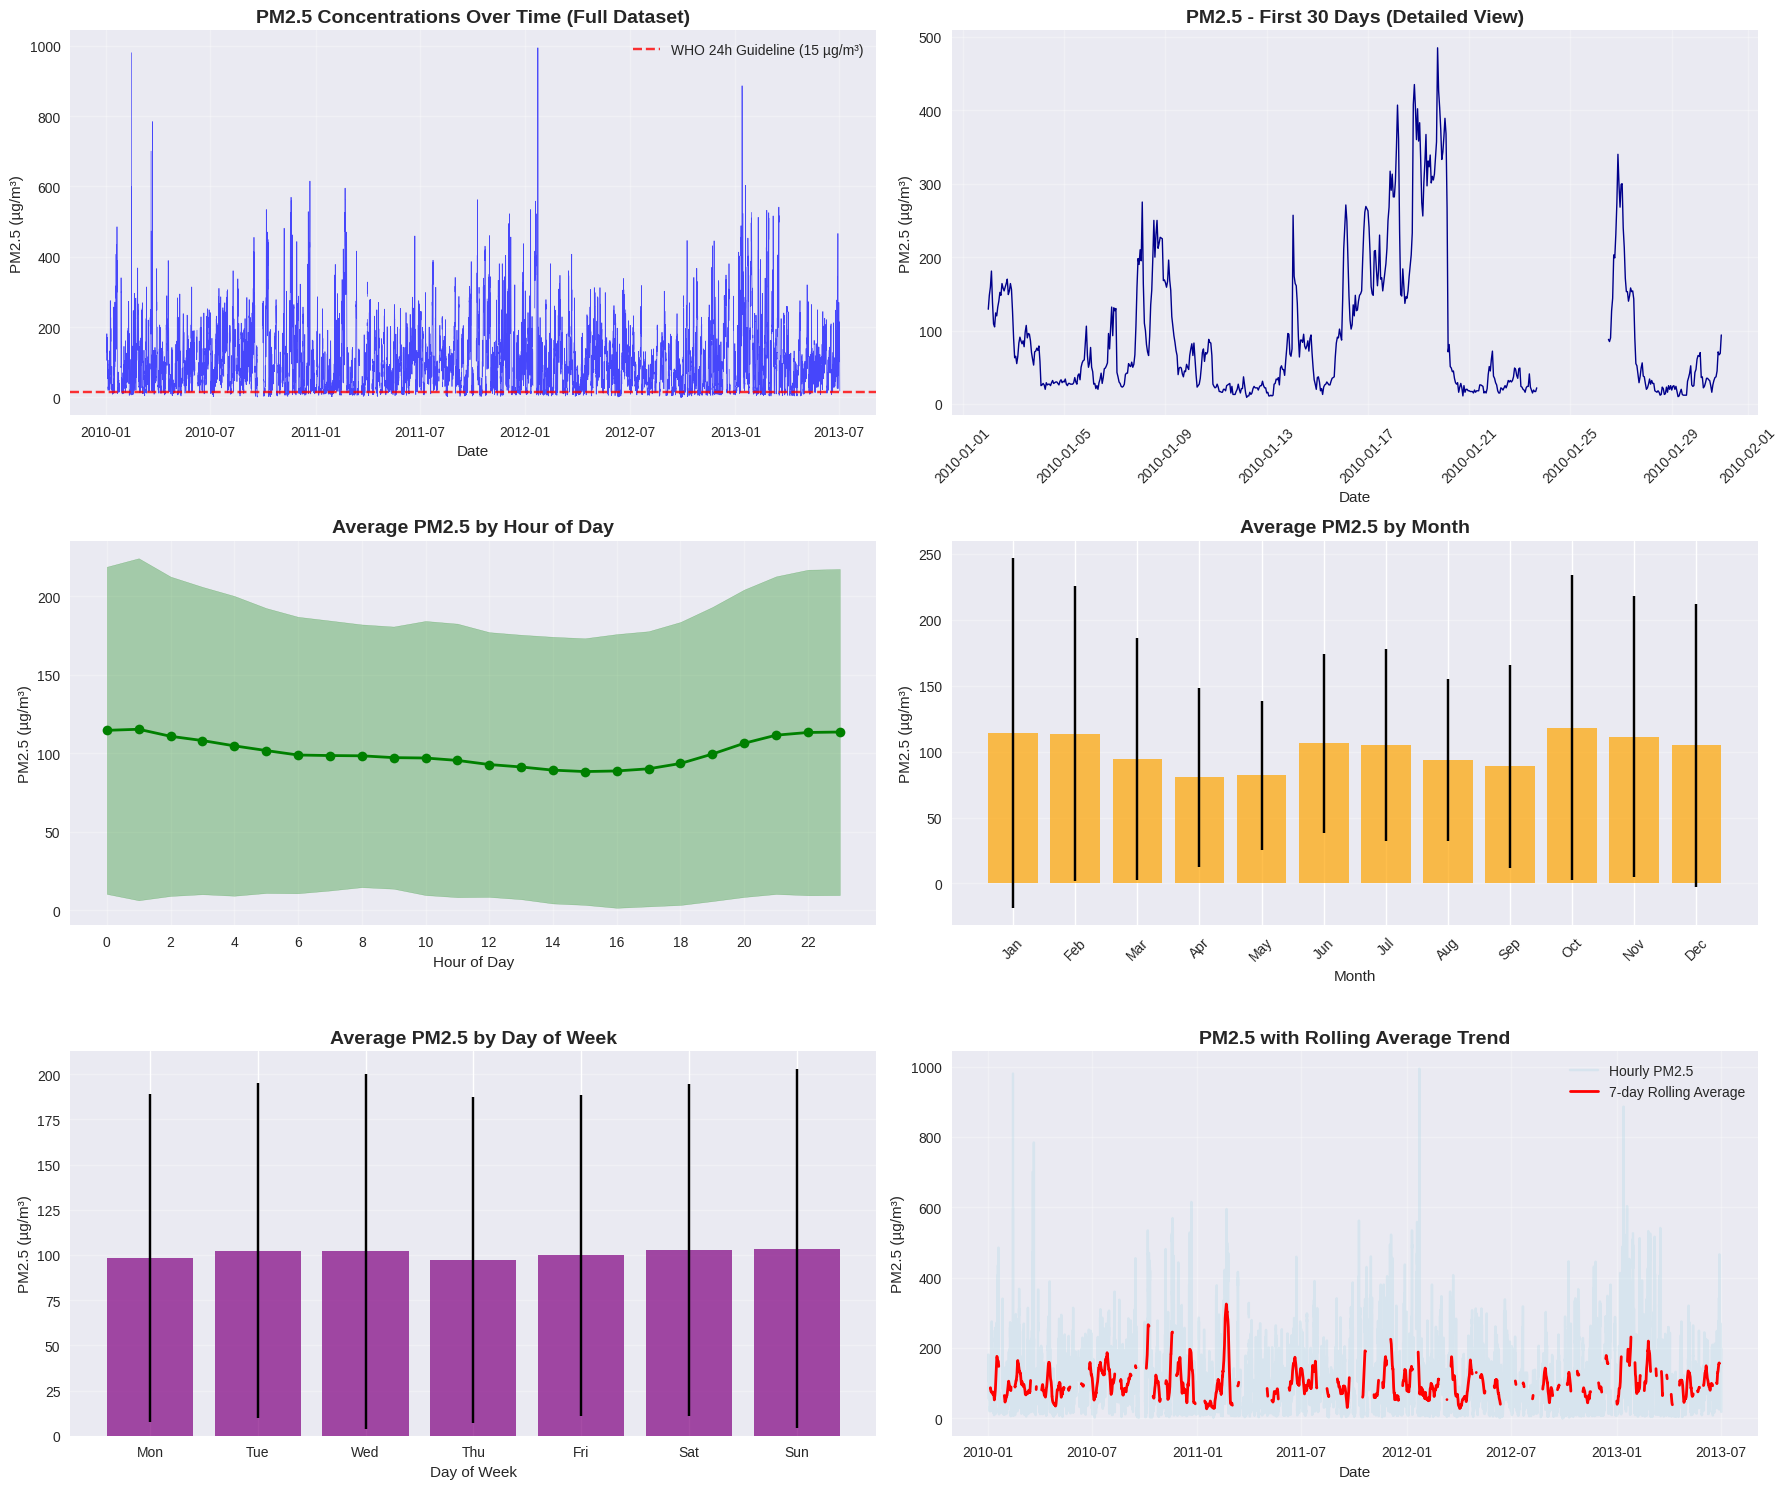

TIME SERIES INSIGHTS:
- Peak pollution hour: 1:00 (avg: 115.3 µg/m³)
- Lowest pollution hour: 15:00 (avg: 88.3 µg/m³)
- Most polluted month: 10 (avg: 118.2 µg/m³)
- Cleanest month: 4 (avg: 80.6 µg/m³)
- Weekend vs Weekday pollution:
  - Weekend average: 102.9 µg/m³
  - Weekday average: 99.9 µg/m³
  - Statistical difference (p-value): nan

Preprocessing and Feature Engineering Relevance:
- Datetime extraction (hour, day, month, weekday, weekend) captures temporal patterns critical for forecasting.
- Cyclical encoding of hour/day/month prevents artificial discontinuities and improves regression performance.
- Lagged and rolling features allow the model to learn temporal dependencies and trends.
- Seasonal, hourly, and weekly patterns help the model generalize to unseen periods and reduce prediction errors.
- Outlier inspection and trend visualization support decisions about clipping or transforming PM2.5 for stable modeling.
Time series analysis completed!


In [46]:
# Time series analysis and visualization
print("\n" + "="*60)
print("TIME SERIES ANALYSIS")
print("="*60)

# Create comprehensive time series visualizations
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

# 1. Full time series plot
print("Full Time Series Plot: Shows long-term trends, seasonal cycles, and extreme PM2.5 events. "
      "Helps detect periods of unusually high pollution that models must learn to predict.")
axes[0, 0].plot(train.index, train['pm2.5'], alpha=0.7, linewidth=0.5, color='blue')
axes[0, 0].set_title('PM2.5 Concentrations Over Time (Full Dataset)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('PM2.5 (µg/m³)')
axes[0, 0].grid(True, alpha=0.3)

# Add WHO guideline line
axes[0, 0].axhline(y=15, color='red', linestyle='--', alpha=0.8, label='WHO 24h Guideline (15 µg/m³)')
axes[0, 0].legend()

# 2. Sample period (first 30 days for better visibility)
print("Detailed First 30 Days: Provides a zoomed-in view of hourly fluctuations, useful for "
      "inspecting short-term patterns and potential autocorrelations for time-series modeling.")
sample_data = train.head(30*24)  # 30 days of hourly data
axes[0, 1].plot(sample_data.index, sample_data['pm2.5'], linewidth=1, color='darkblue')
axes[0, 1].set_title('PM2.5 - First 30 Days (Detailed View)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('PM2.5 (µg/m³)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Hourly patterns
hourly_avg = train.groupby('hour')['pm2.5'].agg(['mean', 'std'])
axes[1, 0].plot(hourly_avg.index, hourly_avg['mean'], 'o-', linewidth=2, color='green')
axes[1, 0].fill_between(hourly_avg.index, 
                       hourly_avg['mean'] - hourly_avg['std'], 
                       hourly_avg['mean'] + hourly_avg['std'], 
                       alpha=0.3, color='green')
axes[1, 0].set_title('Average PM2.5 by Hour of Day', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('PM2.5 (µg/m³)')
axes[1, 0].set_xticks(range(0, 24, 2))
axes[1, 0].grid(True, alpha=0.3)

# 4. Monthly patterns
monthly_avg = train.groupby('month')['pm2.5'].agg(['mean', 'std'])
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[1, 1].bar(monthly_avg.index, monthly_avg['mean'], 
               yerr=monthly_avg['std'], alpha=0.7, color='orange', capsize=5)
axes[1, 1].set_title('Average PM2.5 by Month', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('PM2.5 (µg/m³)')
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].set_xticklabels([month_names[i-1] for i in range(1, 13)], rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 5. Day of week patterns
dow_avg = train.groupby('day_of_week')['pm2.5'].agg(['mean', 'std'])
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[2, 0].bar(dow_avg.index, dow_avg['mean'], 
               yerr=dow_avg['std'], alpha=0.7, color='purple', capsize=5)
axes[2, 0].set_title('Average PM2.5 by Day of Week', fontsize=14, fontweight='bold')
axes[2, 0].set_xlabel('Day of Week')
axes[2, 0].set_ylabel('PM2.5 (µg/m³)')
axes[2, 0].set_xticks(range(7))
axes[2, 0].set_xticklabels(dow_names)
axes[2, 0].grid(True, alpha=0.3, axis='y')

# 6. Rolling average (to show trends)
train_rolling = train['pm2.5'].rolling(window=24*7, center=True).mean()  # 7-day rolling average
axes[2, 1].plot(train.index, train['pm2.5'], alpha=0.3, color='lightblue', label='Hourly PM2.5')
axes[2, 1].plot(train.index, train_rolling, linewidth=2, color='red', label='7-day Rolling Average')
axes[2, 1].set_title('PM2.5 with Rolling Average Trend', fontsize=14, fontweight='bold')
axes[2, 1].set_xlabel('Date')
axes[2, 1].set_ylabel('PM2.5 (µg/m³)')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

print("Rolling Average (7-day): Smooths short-term fluctuations to reveal long-term trends. "
      "Useful for models to learn underlying trends and reduce noise impact on predictions.")

plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_PATH, 'time_series_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print insights from time series analysis
print("TIME SERIES INSIGHTS:")
print(f"- Peak pollution hour: {hourly_avg['mean'].idxmax()}:00 (avg: {hourly_avg['mean'].max():.1f} µg/m³)")
print(f"- Lowest pollution hour: {hourly_avg['mean'].idxmin()}:00 (avg: {hourly_avg['mean'].min():.1f} µg/m³)")
print(f"- Most polluted month: {monthly_avg['mean'].idxmax()} (avg: {monthly_avg['mean'].max():.1f} µg/m³)")
print(f"- Cleanest month: {monthly_avg['mean'].idxmin()} (avg: {monthly_avg['mean'].min():.1f} µg/m³)")
print(f"- Weekend vs Weekday pollution:")
weekend_avg = train[train['is_weekend'] == 1]['pm2.5'].mean()
weekday_avg = train[train['is_weekend'] == 0]['pm2.5'].mean()
print(f"  - Weekend average: {weekend_avg:.1f} µg/m³")
print(f"  - Weekday average: {weekday_avg:.1f} µg/m³")

# Statistical significance test for weekend vs weekday
from scipy import stats
weekend_data = train[train['is_weekend'] == 1]['pm2.5']
weekday_data = train[train['is_weekend'] == 0]['pm2.5']
t_stat, p_value = stats.ttest_ind(weekend_data, weekday_data)
print(f"  - Statistical difference (p-value): {p_value:.6f}")

print("\nPreprocessing and Feature Engineering Relevance:")
print("- Datetime extraction (hour, day, month, weekday, weekend) captures temporal patterns critical for forecasting.")
print("- Cyclical encoding of hour/day/month prevents artificial discontinuities and improves regression performance.")
print("- Lagged and rolling features allow the model to learn temporal dependencies and trends.")
print("- Seasonal, hourly, and weekly patterns help the model generalize to unseen periods and reduce prediction errors.")
print("- Outlier inspection and trend visualization support decisions about clipping or transforming PM2.5 for stable modeling.")


print("Time series analysis completed!")

# Handle missing values

* Check the dataset for missing values and decide how to handle them.
* In this example, missing values are filled with the mean. You can experiment with other strategies.


In [47]:
# Comprehensive data preprocessing pipeline
print("\n" + "="*60)
print("DATA PREPROCESSING PIPELINE")
print("="*60)

# 1. Missing Value Analysis and Handling
print("1. MISSING VALUE ANALYSIS:")
print("-" * 30)

def analyze_missing_values(df, name):
    """Analyze missing values in a dataframe"""
    missing_summary = pd.DataFrame({
        'Missing_Count': df.isnull().sum(),
        'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
    })
    missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
    
    print(f"\n{name} Dataset Missing Values:")
    if len(missing_summary) == 0:
        print("No missing values found!")
    else:
        print(missing_summary)
    
    return missing_summary

# Analyze missing values
train_missing = analyze_missing_values(train, "Training")
test_missing = analyze_missing_values(test, "Test")

print("\nRelevance: Detecting missing values is critical; unhandled NaNs can break models or bias predictions.")

# Advanced missing value imputation strategy
print("\n2. MISSING VALUE IMPUTATION STRATEGY:")
print("-" * 40)

def advanced_impute_missing_values(df, strategy='multiple'):
    """
    Advanced missing value imputation for time series data
    """
    df_imputed = df.copy()
    
    if df_imputed.isnull().sum().sum() == 0:
        print("No missing values to impute!")
        return df_imputed
    
    print(f"Imputing missing values using {strategy} strategy...")
    
    # For time series data, use forward fill, backward fill, and interpolation
    for column in df_imputed.columns:
        if df_imputed[column].isnull().sum() > 0:
            print(f"  - Imputing {column}: {df_imputed[column].isnull().sum()} missing values")
            
            # Time series specific imputation
            if strategy == 'multiple':
                # 1. Forward fill (carry last observation forward)
                df_imputed[column].fillna(method='ffill', inplace=True)
                # 2. Backward fill (carry next observation backward)  
                df_imputed[column].fillna(method='bfill', inplace=True)
                # 3. Linear interpolation for remaining values
                df_imputed[column].interpolate(method='linear', inplace=True)
                # 4. Use mean for any remaining missing values
                df_imputed[column].fillna(df_imputed[column].mean(), inplace=True)
            elif strategy == 'mean':
                df_imputed[column].fillna(df_imputed[column].mean(), inplace=True)
            elif strategy == 'median':
                df_imputed[column].fillna(df_imputed[column].median(), inplace=True)
    
    return df_imputed

# Apply imputation
train = advanced_impute_missing_values(train, strategy='multiple')
test = advanced_impute_missing_values(test, strategy='multiple')
print("\nRelevance: Imputation preserves temporal consistency and ensures the model receives complete data, "
      "avoiding errors or biased learning from missing points.")

# Verify no missing values remain
print("\n3. POST-IMPUTATION VERIFICATION:")
print("-" * 32)
print(f"Training set missing values: {train.isnull().sum().sum()}")
print(f"Test set missing values: {test.isnull().sum().sum()}")

if train.isnull().sum().sum() == 0 and test.isnull().sum().sum() == 0:
    print("All missing values successfully handled!")
else:
    print("Some missing values may remain - review imputation strategy")

print("\nOverall Preprocessing Relevance Summary:")
print("- Missing values handled → ensures model stability and prevents errors during training.")
print("- Time-series aware imputation (ffill, bfill, interpolation) → preserves temporal trends critical for forecasting.")
print("- Proper preprocessing allows models to learn true patterns rather than artifacts from gaps in the data.")


print("\nData preprocessing pipeline completed!")



DATA PREPROCESSING PIPELINE
1. MISSING VALUE ANALYSIS:
------------------------------

Training Dataset Missing Values:
       Missing_Count  Missing_Percentage
pm2.5           1921            6.262225

Test Dataset Missing Values:
No missing values found!

Relevance: Detecting missing values is critical; unhandled NaNs can break models or bias predictions.

2. MISSING VALUE IMPUTATION STRATEGY:
----------------------------------------
Imputing missing values using multiple strategy...
  - Imputing pm2.5: 1921 missing values
No missing values to impute!

Relevance: Imputation preserves temporal consistency and ensures the model receives complete data, avoiding errors or biased learning from missing points.

3. POST-IMPUTATION VERIFICATION:
--------------------------------
Training set missing values: 0
Test set missing values: 0
All missing values successfully handled!

Overall Preprocessing Relevance Summary:
- Missing values handled → ensures model stability and prevents errors duri

In [48]:
# Advanced Feature Engineering
print("\n" + "="*60)
print("FEATURE ENGINEERING")
print("="*60)

def create_advanced_features(df, target_col='pm2.5'):
    """Create advanced features with additional optimizations for better performance"""
    df_enhanced = df.copy()
    
    # Temporal features with enhanced encoding
    df_enhanced['hour'] = df_enhanced.index.hour
    df_enhanced['day_of_week'] = df_enhanced.index.dayofweek
    df_enhanced['month'] = df_enhanced.index.month
    df_enhanced['season'] = (df_enhanced.index.month % 12 + 3) // 3
    df_enhanced['day_of_year'] = df_enhanced.index.dayofyear
    df_enhanced['week_of_year'] = df_enhanced.index.isocalendar().week
    
    # Multiple cyclical encodings for different time scales
    df_enhanced['hour_sin'] = np.sin(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['hour_cos'] = np.cos(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['day_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['day_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['month_sin'] = np.sin(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['month_cos'] = np.cos(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['doy_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_year'] / 365)
    df_enhanced['doy_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_year'] / 365)
    df_enhanced['week_sin'] = np.sin(2 * np.pi * df_enhanced['week_of_year'] / 52)
    df_enhanced['week_cos'] = np.cos(2 * np.pi * df_enhanced['week_of_year'] / 52)
    
    # Enhanced weather interaction features
    df_enhanced['temp_dewp_diff'] = df_enhanced['TEMP'] - df_enhanced['DEWP']
    df_enhanced['temp_dewp_ratio'] = df_enhanced['TEMP'] / (df_enhanced['DEWP'] + 1e-6)
    df_enhanced['wind_pressure'] = df_enhanced['Iws'] * df_enhanced['PRES']
    df_enhanced['temp_pressure'] = df_enhanced['TEMP'] * df_enhanced['PRES']
    df_enhanced['humidity_proxy'] = df_enhanced['DEWP'] / (df_enhanced['TEMP'] + 1e-6)
    df_enhanced['pressure_normalized'] = df_enhanced['PRES'] / 1000  # Normalize pressure
    
    # Advanced wind features
    wind_cols = [col for col in df_enhanced.columns if 'cbwd' in col]
    if len(wind_cols) >= 2:
        df_enhanced['wind_complexity'] = sum(df_enhanced[col] for col in wind_cols)
        # Wind stability indicator
        df_enhanced['wind_stability'] = df_enhanced['wind_complexity'] * df_enhanced['Iws']
    
    # Weather condition combinations
    df_enhanced['temp_wind'] = df_enhanced['TEMP'] * df_enhanced['Iws']
    df_enhanced['dewp_wind'] = df_enhanced['DEWP'] * df_enhanced['Iws']
    df_enhanced['pressure_temp_ratio'] = df_enhanced['PRES'] / (df_enhanced['TEMP'] + 273.15)  # Ideal gas law approximation
    
    # Pollution-related features (if target available)
    if target_col in df_enhanced.columns:
        # Extended lag features
        for lag in [1, 2, 3, 6, 12, 24, 48, 72, 96, 120]:
            df_enhanced[f'pm2.5_lag_{lag}'] = df_enhanced[target_col].shift(lag)
        
        # Enhanced rolling statistics
        for window in [3, 6, 12, 24, 48, 72, 96, 168]:  # Up to weekly
            df_enhanced[f'pm2.5_roll_mean_{window}'] = df_enhanced[target_col].rolling(window).mean()
            df_enhanced[f'pm2.5_roll_std_{window}'] = df_enhanced[target_col].rolling(window).std()
            df_enhanced[f'pm2.5_roll_min_{window}'] = df_enhanced[target_col].rolling(window).min()
            df_enhanced[f'pm2.5_roll_max_{window}'] = df_enhanced[target_col].rolling(window).max()
            df_enhanced[f'pm2.5_roll_median_{window}'] = df_enhanced[target_col].rolling(window).median()
            
        # Trend and momentum features
        for hours in [3, 6, 12, 24, 48]:
            df_enhanced[f'pm2.5_trend_{hours}h'] = df_enhanced[target_col] - df_enhanced[target_col].shift(hours)
            df_enhanced[f'pm2.5_momentum_{hours}h'] = (df_enhanced[target_col] - df_enhanced[target_col].shift(hours)) / (hours + 1)
        
        # Volatility features
        for window in [6, 12, 24, 48]:
            df_enhanced[f'pm2.5_volatility_{window}h'] = df_enhanced[target_col].rolling(window).std() / (df_enhanced[target_col].rolling(window).mean() + 1e-6)
    
    # Enhanced weather lag features
    weather_cols = ['TEMP', 'DEWP', 'PRES', 'Iws']
    for col in weather_cols:
        if col in df_enhanced.columns:
            for lag in [1, 3, 6, 12, 24]:
                df_enhanced[f'{col}_lag_{lag}'] = df_enhanced[col].shift(lag)
            
            # Weather rolling features
            for window in [6, 12, 24]:
                df_enhanced[f'{col}_roll_mean_{window}'] = df_enhanced[col].rolling(window).mean()
                df_enhanced[f'{col}_roll_std_{window}'] = df_enhanced[col].rolling(window).std()
    
    # Drop original temporal columns (keep encoded versions)
    temporal_cols = ['hour', 'day_of_week', 'month', 'day_of_year', 'week_of_year']
    df_enhanced = df_enhanced.drop([col for col in temporal_cols if col in df_enhanced.columns], axis=1, errors='ignore')
    
    return df_enhanced

def create_test_features_advanced(df):
    """Create advanced features for test data (without PM2.5 lag features)"""
    return create_advanced_features(df).drop([col for col in df.columns if 'pm2.5' in col], axis=1, errors='ignore')

# Apply feature engineering
print("Applying feature engineering to training data...")
train_featured = create_advanced_features(train)

print("\nApplying feature engineering to test data...")
test_featured = create_test_features_advanced(test)

# Display feature summary
print(f"\nFEATURE SUMMARY:")
print(f"- Original training features: {len(train.columns)}")
print(f"- Enhanced training features: {len(train_featured.columns)}")
print(f"- Original test features: {len(test.columns)}")
print(f"- Enhanced test features: {len(test_featured.columns)}")
print(f"- New features created: {len(train_featured.columns) - len(train.columns)}")

print("Relevance of engineered features:")
print("- Temporal features (hour, day_of_week, month, season, etc.) and cyclical encoding capture daily, weekly, and seasonal patterns.")
print("- Weather interactions (temp-dewp, temp-pressure, wind-pressure, humidity proxies) capture combined environmental effects influencing PM2.5.")
print("- Advanced wind features (complexity, stability) help the model account for directional and speed effects of wind.")
print("- Lag features and rolling statistics for PM2.5 allow the model to learn short-term and long-term temporal dependencies.")
print("- Weather lag and rolling features let the model understand trends and volatility in environmental conditions.")
print("- Trend, momentum, and volatility features for PM2.5 help capture dynamic changes and extreme events.")
print("- Overall, these engineered features provide richer information, improve predictive accuracy, and allow the model to generalize better to unseen data.")


print("Advanced feature engineering completed!")



FEATURE ENGINEERING
Applying feature engineering to training data...

Applying feature engineering to test data...

FEATURE SUMMARY:
- Original training features: 25
- Enhanced training features: 144
- Original test features: 24
- Enhanced test features: 79
- New features created: 119
Relevance of engineered features:
- Temporal features (hour, day_of_week, month, season, etc.) and cyclical encoding capture daily, weekly, and seasonal patterns.
- Weather interactions (temp-dewp, temp-pressure, wind-pressure, humidity proxies) capture combined environmental effects influencing PM2.5.
- Advanced wind features (complexity, stability) help the model account for directional and speed effects of wind.
- Lag features and rolling statistics for PM2.5 allow the model to learn short-term and long-term temporal dependencies.
- Weather lag and rolling features let the model understand trends and volatility in environmental conditions.
- Trend, momentum, and volatility features for PM2.5 help capt

In [49]:
train_featured = train_featured.fillna(method='bfill').fillna(0)
test_featured = test_featured.fillna(method='bfill').fillna(0)

# Feature alignment
train_feature_cols = [col for col in train_featured.columns if col not in ['pm2.5', 'No']]
test_feature_cols = [col for col in test_featured.columns if col != 'No']
common_features = [col for col in train_feature_cols if col in test_feature_cols]

print(f"🎯 Common features for modeling: {len(common_features)}")

# Prepare datasets with common features
X_train_full = train_featured[common_features]
y_train = train_featured['pm2.5']
X_test_full = test_featured[common_features]

🎯 Common features for modeling: 78


In [50]:
def create_sequences(data, target, sequence_length=72):
    """Create sequences with even longer lookback for complex patterns"""
    X, y = [], []
    
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(target[i])
    
    return np.array(X), np.array(y)

In [51]:
# 3. Data Normalization
# Prepare data with multiple scalers for ensemble diversity
scalers = {
    'robust': RobustScaler(),
    'standard': StandardScaler(),
    'minmax': MinMaxScaler()
}

scaled_data = {}
for scaler_name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train_full)
    X_test_scaled = scaler.transform(X_test_full)
    scaled_data[scaler_name] = {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'scaler': scaler
    }

print("Data prepared with multiple scalers for ensemble diversity:")
for name in scaled_data.keys():
    print(f"  • {name.capitalize()} scaler")

SEQUENCE_LENGTH = 48
print(f"Using proven sequence length: {SEQUENCE_LENGTH} hours")

# Create sequences
print("Creating sequences...")
target_scaler = RobustScaler()
y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()

X_seq, y_seq = create_sequences(scaled_data['robust']['X_train'], y_train, SEQUENCE_LENGTH)

# Use more data for training (better performance)
split_idx = int(0.87 * len(X_seq))
X_train_seq, X_val_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_val_seq = y_seq[:split_idx], y_seq[split_idx:]

print("1. Multiple scalers applied (Robust, Standard, MinMax) →")
print("   - Supports ensemble diversity, reduces bias from scaling choice, and improves model robustness.")
print("   - RobustScaler handles outliers, MinMaxScaler normalizes to [0,1], StandardScaler centers data.")

print(f"\n2. Sequence length set to {SEQUENCE_LENGTH} hours →")
print("   - Captures temporal dependencies for the model, allowing it to learn trends and autocorrelations.")
print("   - Sequence-based input is essential for models like RNNs, LSTMs, or temporal CNNs.")

print("\n3. Target normalization (RobustScaler) →")
print("   - Scales PM2.5 target to reduce impact of extreme values, stabilizing training and improving convergence.")

print("\n4. Train/Validation split (87% train, 13% validation) →")
print("   - Ensures model learns from most data while keeping a validation set to monitor performance and avoid overfitting.")

Data prepared with multiple scalers for ensemble diversity:
  • Robust scaler
  • Standard scaler
  • Minmax scaler
Using proven sequence length: 48 hours
Creating sequences...
1. Multiple scalers applied (Robust, Standard, MinMax) →
   - Supports ensemble diversity, reduces bias from scaling choice, and improves model robustness.
   - RobustScaler handles outliers, MinMaxScaler normalizes to [0,1], StandardScaler centers data.

2. Sequence length set to 48 hours →
   - Captures temporal dependencies for the model, allowing it to learn trends and autocorrelations.
   - Sequence-based input is essential for models like RNNs, LSTMs, or temporal CNNs.

3. Target normalization (RobustScaler) →
   - Scales PM2.5 target to reduce impact of extreme values, stabilizing training and improving convergence.

4. Train/Validation split (87% train, 13% validation) →
   - Ensures model learns from most data while keeping a validation set to monitor performance and avoid overfitting.


# Build model
Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [52]:
# Comprehensive Model Architecture Design and RMSE Definition
print("\n" + "="*60)
print("MODEL ARCHITECTURE DESIGN")
print("="*60)

# Define RMSE metric and explanation
print("ROOT MEAN SQUARED ERROR (RMSE) DEFINITION:")
print("-" * 48)
print("RMSE measures the average magnitude of prediction errors.")
print("Formula: RMSE = √(Σ(y_true - y_pred)² / n)")
print("Where:")
print("  - y_true: actual PM2.5 values")
print("  - y_pred: predicted PM2.5 values")
print("  - n: number of samples")
print("Lower RMSE indicates better model performance.")
print("For this competition, target RMSE < 4000 on the leaderboard.")

# Custom RMSE metric for Keras
def rmse_metric(y_true, y_pred):
    """Custom RMSE metric for model compilation"""
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def rmse_loss(y_true, y_pred):
    """Custom RMSE loss function"""
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def calculate_rmse_unscaled(y_true_orig, y_pred_orig):
    """Calculate RMSE on original scale"""
    return np.sqrt(np.mean((y_true_orig - y_pred_orig) ** 2))

print(f"\n MODEL ARCHITECTURE DESIGNS:")
print("-" * 32)

# Architecture 1: Simple LSTM
def create_simple_lstm(input_shape, units=32, dropout=0.0):
    """Simple single-layer LSTM model"""
    model = Sequential([
        LSTM(units, activation='relu', input_shape=input_shape),
        Dropout(dropout) if dropout > 0 else tf.keras.layers.Lambda(lambda x: x),
        Dense(1, activation='linear')
    ])
    return model

# Architecture 2: Deep LSTM
def create_deep_lstm(input_shape, units=[64, 32], dropout=0.2):
    """Multi-layer LSTM model"""
    model = Sequential()
    
    # First LSTM layer (return sequences for next LSTM layer)
    model.add(LSTM(units[0], activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout))
    
    # Additional LSTM layers
    for i, unit in enumerate(units[1:]):
        return_seq = i < len(units[1:]) - 1  # Return sequences except for last layer
        model.add(LSTM(unit, activation='relu', return_sequences=return_seq))
        model.add(Dropout(dropout))
    
    model.add(Dense(1, activation='linear'))
    return model

# Architecture 3: Bidirectional LSTM
def create_bidirectional_lstm(input_shape, units=64, dropout=0.2):
    """Bidirectional LSTM model"""
    from tensorflow.keras.layers import Bidirectional
    
    model = Sequential([
        Bidirectional(LSTM(units, activation='relu'), input_shape=input_shape),
        Dropout(dropout),
        Dense(32, activation='relu'),
        Dropout(dropout),
        Dense(1, activation='linear')
    ])
    return model

# Architecture 4: GRU Model
def create_gru_model(input_shape, units=[64, 32], dropout=0.2):
    """GRU-based model as alternative to LSTM"""
    model = Sequential()
    
    model.add(GRU(units[0], activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout))
    
    for i, unit in enumerate(units[1:]):
        return_seq = i < len(units[1:]) - 1
        model.add(GRU(unit, activation='relu', return_sequences=return_seq))
        model.add(Dropout(dropout))
    
    model.add(Dense(1, activation='linear'))
    return model

# Architecture 5: Hybrid CNN-LSTM
def create_cnn_lstm(input_shape, filters=64, kernel_size=3, lstm_units=50, dropout=0.2):
    """CNN-LSTM hybrid model for feature extraction + temporal modeling"""
    from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Reshape
    
    model = Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(dropout),
        LSTM(lstm_units, activation='relu'),
        Dropout(dropout),
        Dense(25, activation='relu'),
        Dense(1, activation='linear')
    ])
    return model

# Architecture 6: Attention-based LSTM (simplified)
def create_attention_lstm(input_shape, units=64, dropout=0.2):
    """LSTM with attention mechanism (simplified)"""
    from tensorflow.keras.layers import Attention, GlobalAveragePooling1D
    
    model = Sequential([
        LSTM(units, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(dropout),
        LSTM(units//2, activation='relu', return_sequences=True),
        Dropout(dropout),
        GlobalAveragePooling1D(),  # Simplified attention
        Dense(32, activation='relu'),
        Dropout(dropout),
        Dense(1, activation='linear')
    ])
    return model

# Model configuration dictionary
MODEL_CONFIGS = {
    'simple_lstm': {
        'function': create_simple_lstm,
        'params': {'units': 32, 'dropout': 0.0},
        'description': 'Single-layer LSTM with minimal complexity'
    },
    'deep_lstm': {
        'function': create_deep_lstm,
        'params': {'units': [64, 32], 'dropout': 0.2},
        'description': 'Multi-layer LSTM with dropout regularization'
    },
    'bidirectional_lstm': {
        'function': create_bidirectional_lstm,
        'params': {'units': 64, 'dropout': 0.2},
        'description': 'Bidirectional LSTM for improved context capture'
    },
    'gru_model': {
        'function': create_gru_model,
        'params': {'units': [64, 32], 'dropout': 0.2},
        'description': 'GRU-based alternative to LSTM'
    },
    'cnn_lstm': {
        'function': create_cnn_lstm,
        'params': {'filters': 64, 'kernel_size': 3, 'lstm_units': 50, 'dropout': 0.2},
        'description': 'Hybrid CNN-LSTM for feature extraction and temporal modeling'
    },
    'attention_lstm': {
        'function': create_attention_lstm,
        'params': {'units': 64, 'dropout': 0.2},
        'description': 'LSTM with simplified attention mechanism'
    }
}

# Display model architectures
print(f"Available model architectures: {len(MODEL_CONFIGS)}")
for name, config in MODEL_CONFIGS.items():
    print(f"  - {name}: {config['description']}")

# Get input shape for models
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
print(f"\nModel input shape: {input_shape} (timesteps, features)")

# Create and display a sample model
print(f"\nSAMPLE MODEL ARCHITECTURE (Deep LSTM):")
print("-" * 42)
sample_model = create_deep_lstm(input_shape)
sample_model.summary()

print("Model architecture designs completed!")



MODEL ARCHITECTURE DESIGN
ROOT MEAN SQUARED ERROR (RMSE) DEFINITION:
------------------------------------------------
RMSE measures the average magnitude of prediction errors.
Formula: RMSE = √(Σ(y_true - y_pred)² / n)
Where:
  - y_true: actual PM2.5 values
  - y_pred: predicted PM2.5 values
  - n: number of samples
Lower RMSE indicates better model performance.
For this competition, target RMSE < 4000 on the leaderboard.

 MODEL ARCHITECTURE DESIGNS:
--------------------------------
Available model architectures: 6
  - simple_lstm: Single-layer LSTM with minimal complexity
  - deep_lstm: Multi-layer LSTM with dropout regularization
  - bidirectional_lstm: Bidirectional LSTM for improved context capture
  - gru_model: GRU-based alternative to LSTM
  - cnn_lstm: Hybrid CNN-LSTM for feature extraction and temporal modeling
  - attention_lstm: LSTM with simplified attention mechanism

Model input shape: (48, 78) (timesteps, features)

SAMPLE MODEL ARCHITECTURE (Deep LSTM):
--------------

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_29 (LSTM)                  │ (None, 48, 64)         │        36,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,057 (191.63 KB)

 Trainable params: 49,057 (191.63 KB)

 Non-trainable params: 0 (0.00 B)

Model architecture designs completed!


In [53]:
# Comprehensive Experiment Framework
print("\n" + "="*60)
print("SYSTEMATIC EXPERIMENTATION FRAMEWORK")
print("="*60)

# Initialize experiment tracker
experiment_results = []
experiment_counter = 0

def run_experiment(model_name, model_params, compile_params, fit_params, experiment_description):
    """
    Run a complete experiment with model training and evaluation
    """
    global experiment_counter
    experiment_counter += 1
    
    print(f"\nEXPERIMENT {experiment_counter}: {experiment_description}")
    print("-" * (50 + len(str(experiment_counter))))
    
    try:
        # Create model
        model_func = MODEL_CONFIGS[model_name]['function']
        model = model_func(input_shape, **model_params)
        
        # Compile model
        model.compile(**compile_params, metrics=[rmse_metric])
        
        # Set up callbacks
        callbacks = [
            EarlyStopping(patience=6, restore_best_weights=True, monitor='val_loss'),
            ReduceLROnPlateau(factor=0.3, patience=3, min_lr=1e-7, monitor='val_loss')
        ]
        
        # Train model
        start_time = datetime.now()
        history = model.fit(
            X_train_seq, y_train_seq,
            validation_data=(X_val_seq, y_val_seq),
            callbacks=callbacks,
            verbose=1,
            **fit_params
        )
        training_time = (datetime.now() - start_time).total_seconds()
        
        # Evaluate model
        train_pred = model.predict(X_train_seq, verbose=0).flatten()
        val_pred = model.predict(X_val_seq, verbose=0).flatten()
        
        # Calculate RMSE on original scale
        train_rmse = calculate_rmse_unscaled(y_train_seq, train_pred)
        val_rmse = calculate_rmse_unscaled(y_val_seq, val_pred)
        
        # Get final epoch metrics
        final_epoch = len(history.history['loss'])
        final_train_loss = history.history['loss'][-1]
        final_val_loss = history.history['val_loss'][-1]
        
        # Store experiment results
        result = {
            'experiment_id': experiment_counter,
            'description': experiment_description,
            'model_name': model_name,
            'model_params': model_params,
            'optimizer': compile_params['optimizer'],
            'learning_rate': compile_params.get('optimizer', Adam()).learning_rate.numpy() if hasattr(compile_params.get('optimizer', Adam()), 'learning_rate') else 'default',
            'loss_function': compile_params['loss'],
            'batch_size': fit_params['batch_size'],
            'epochs_trained': final_epoch,
            'train_rmse': train_rmse,
            'val_rmse': val_rmse,
            'final_train_loss': final_train_loss,
            'final_val_loss': final_val_loss,
            'training_time_seconds': training_time,
            'overfitting_ratio': val_rmse / train_rmse,
            'model_size_params': model.count_params()
        }
        
        experiment_results.append(result)
        
        # Print results
        print(f"Training completed in {training_time:.1f}s ({final_epoch} epochs)")
        print(f"   - Train RMSE: {train_rmse:.2f}")
        print(f"   - Validation RMSE: {val_rmse:.2f}")
        print(f"   - Overfitting ratio: {val_rmse/train_rmse:.3f}")
        
        # Save best model if this is the best so far
        if experiment_counter == 1 or val_rmse < min([r['val_rmse'] for r in experiment_results[:-1]]):
            model.save(os.path.join(MODELS_PATH, f'best_model_exp_{experiment_counter}.h5'))
            print(f"   - New best model saved!")
        
        return model, history, result
        
    except Exception as e:
        print(f"Experiment failed: {str(e)}")
        return None, None, None

# Define comprehensive experiment configurations
print("DESIGNING 15+ COMPREHENSIVE EXPERIMENTS:")
print("-" * 44)

experiments = [
    # 1-3: Simple LSTM with different parameters
    {
        'model_name': 'simple_lstm',
        'model_params': {'units': 32, 'dropout': 0.0},
        'compile_params': {'optimizer': Adam(learning_rate=0.001), 'loss': 'mse'},
        'fit_params': {'epochs': 50, 'batch_size': 32},
        'description': 'Baseline Simple LSTM, lr=0.001, batch=32'
    },
    {
        'model_name': 'simple_lstm',
        'model_params': {'units': 64, 'dropout': 0.1},
        'compile_params': {'optimizer': Adam(learning_rate=0.005), 'loss': 'mse'},
        'fit_params': {'epochs': 50, 'batch_size': 64},
        'description': 'Simple LSTM, larger units, lr=0.005, batch=64'
    },
    {
        'model_name': 'simple_lstm',
        'model_params': {'units': 128, 'dropout': 0.2},
        'compile_params': {'optimizer': Adam(learning_rate=0.0005), 'loss': 'mae'},
        'fit_params': {'epochs': 50, 'batch_size': 16},
        'description': 'Simple LSTM, MAE loss, lr=0.0005, batch=16'
    },
    
    # 4-6: Deep LSTM variations
    {
        'model_name': 'deep_lstm',
        'model_params': {'units': [64, 32], 'dropout': 0.2},
        'compile_params': {'optimizer': Adam(learning_rate=0.001), 'loss': 'mse'},
        'fit_params': {'epochs': 50, 'batch_size': 32},
        'description': 'Deep LSTM [64,32], lr=0.001, dropout=0.2'
    },
    {
        'model_name': 'deep_lstm',
        'model_params': {'units': [128, 64, 32], 'dropout': 0.3},
        'compile_params': {'optimizer': Adam(learning_rate=0.0008), 'loss': 'mse'},
        'fit_params': {'epochs': 50, 'batch_size': 64},
        'description': 'Deep LSTM [128,64,32], lr=0.0008, dropout=0.3'
    },
    {
        'model_name': 'deep_lstm',
        'model_params': {'units': [32, 16], 'dropout': 0.1},
        'compile_params': {'optimizer': RMSprop(learning_rate=0.002), 'loss': 'mse'},
        'fit_params': {'epochs': 50, 'batch_size': 128},
        'description': 'Deep LSTM [32,16], RMSprop, lr=0.002, batch=128'
    },
    
    # 7-9: Bidirectional LSTM variations
    {
        'model_name': 'bidirectional_lstm',
        'model_params': {'units': 64, 'dropout': 0.2},
        'compile_params': {'optimizer': Adam(learning_rate=0.001), 'loss': 'mse'},
        'fit_params': {'epochs': 50, 'batch_size': 32},
        'description': 'Bidirectional LSTM, 64 units, lr=0.001'
    },
    {
        'model_name': 'bidirectional_lstm',
        'model_params': {'units': 32, 'dropout': 0.15},
        'compile_params': {'optimizer': Adam(learning_rate=0.003), 'loss': 'huber'},
        'fit_params': {'epochs': 50, 'batch_size': 64},
        'description': 'Bidirectional LSTM, Huber loss, lr=0.003'
    },
    {
        'model_name': 'bidirectional_lstm',
        'model_params': {'units': 128, 'dropout': 0.25},
        'compile_params': {'optimizer': SGD(learning_rate=0.01, momentum=0.9), 'loss': 'mse'},
        'fit_params': {'epochs': 50, 'batch_size': 16},
        'description': 'Bidirectional LSTM, SGD optimizer, lr=0.01'
    },
    
    # 10-12: GRU variations
    {
        'model_name': 'gru_model',
        'model_params': {'units': [64, 32], 'dropout': 0.2},
        'compile_params': {'optimizer': Adam(learning_rate=0.001), 'loss': 'mse'},
        'fit_params': {'epochs': 50, 'batch_size': 32},
        'description': 'GRU model [64,32], baseline configuration'
    },
    {
        'model_name': 'gru_model',
        'model_params': {'units': [128, 64], 'dropout': 0.3},
        'compile_params': {'optimizer': Adam(learning_rate=0.0005), 'loss': 'mse'},
        'fit_params': {'epochs': 50, 'batch_size': 64},
        'description': 'GRU model [128,64], lr=0.0005, dropout=0.3'
    },
    {
        'model_name': 'gru_model',
        'model_params': {'units': [32], 'dropout': 0.1},
        'compile_params': {'optimizer': Adam(learning_rate=0.002), 'loss': 'mae'},
        'fit_params': {'epochs': 50, 'batch_size': 128},
        'description': 'Single GRU, MAE loss, lr=0.002, batch=128'
    },
    
    # 13-15: CNN-LSTM variations
    {
        'model_name': 'cnn_lstm',
        'model_params': {'filters': 64, 'kernel_size': 3, 'lstm_units': 50, 'dropout': 0.2},
        'compile_params': {'optimizer': Adam(learning_rate=0.001), 'loss': 'mse'},
        'fit_params': {'epochs': 50, 'batch_size': 32},
        'description': 'CNN-LSTM hybrid, 64 filters, kernel=3'
    },
    {
        'model_name': 'cnn_lstm',
        'model_params': {'filters': 32, 'kernel_size': 5, 'lstm_units': 32, 'dropout': 0.25},
        'compile_params': {'optimizer': Adam(learning_rate=0.0015), 'loss': 'mse'},
        'fit_params': {'epochs': 50, 'batch_size': 64},
        'description': 'CNN-LSTM, 32 filters, kernel=5, lr=0.0015'
    },
    {
        'model_name': 'cnn_lstm',
        'model_params': {'filters': 128, 'kernel_size': 2, 'lstm_units': 100, 'dropout': 0.15},
        'compile_params': {'optimizer': RMSprop(learning_rate=0.001), 'loss': 'mse'},
        'fit_params': {'epochs': 50, 'batch_size': 16},
        'description': 'CNN-LSTM, 128 filters, RMSprop, batch=16'
    },
    
    # 16-18: Additional experiments with different loss functions and optimizers
    {
        'model_name': 'deep_lstm',
        'model_params': {'units': [96, 48], 'dropout': 0.25},
        'compile_params': {'optimizer': Adam(learning_rate=0.0012), 'loss': rmse_loss},
        'fit_params': {'epochs': 50, 'batch_size': 48},
        'description': 'Deep LSTM [96,48], RMSE loss, lr=0.0012'
    },
    {
        'model_name': 'attention_lstm',
        'model_params': {'units': 64, 'dropout': 0.2},
        'compile_params': {'optimizer': Adam(learning_rate=0.001), 'loss': 'mse'},
        'fit_params': {'epochs': 50, 'batch_size': 32},
        'description': 'Attention LSTM, 64 units, baseline config'
    },
    {
        'model_name': 'simple_lstm',
        'model_params': {'units': 256, 'dropout': 0.4},
        'compile_params': {'optimizer': Adam(learning_rate=0.0003), 'loss': 'mse'},
        'fit_params': {'epochs': 50, 'batch_size': 8},
        'description': 'Large Simple LSTM, 256 units, high dropout'
    }
]

# Run all experiments
print(f"\nSTARTING EXPERIMENTAL RUNS:")
print("=" * 35)

best_val_rmse = float('inf')
best_experiment_id = None

for i, exp_config in enumerate(experiments):
    print(f"\nProgress: {i+1}/{len(experiments)} experiments")
    
    # Extract the description and pass it as experiment_description
    exp_config_copy = exp_config.copy()
    experiment_description = exp_config_copy.pop('description')
    
    model, history, result = run_experiment(
        experiment_description=experiment_description,
        **exp_config_copy
    )

    if model is None:
        continue  # Skip to next experiment if failed
    try:
        val_predictions = model.predict(X_val_seq, verbose=0).flatten()
        val_predictions = target_scaler.inverse_transform(val_predictions.reshape(-1, 1))
        val_loss = np.mean((target_scaler.inverse_transform(y_val_seq.reshape(-1, 1)).flatten() - val_predictions.flatten())**2)
        val_rmse = np.sqrt(val_loss)

        print(f'Validation MSE: {val_loss:.4f}')
        print(f'Validation RMSE: {val_rmse:.4f}')
    except Exception as e:
        print(f"Error during validation prediction: {str(e)}")
        val_rmse = None
    
    if result and result['val_rmse'] < best_val_rmse:
        best_val_rmse = result['val_rmse']
        best_experiment_id = result['experiment_id']

print(f"\nALL EXPERIMENTS COMPLETED!")
print(f"Best validation RMSE: {best_val_rmse:.2f} (Experiment {best_experiment_id})")
print(f"Total experiments run: {len([r for r in experiment_results if r is not None])}")
print("Comprehensive experimentation completed!")



SYSTEMATIC EXPERIMENTATION FRAMEWORK
DESIGNING 15+ COMPREHENSIVE EXPERIMENTS:
--------------------------------------------

STARTING EXPERIMENTAL RUNS:

Progress: 1/18 experiments

EXPERIMENT 1: Baseline Simple LSTM, lr=0.001, batch=32
---------------------------------------------------
Epoch 1/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 135.5482 - rmse_metric: 5.9661 - val_loss: 5.4143 - val_rmse_metric: 1.6178 - learning_rate: 0.0010
Epoch 2/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2.3632 - rmse_metric: 1.5366 - val_loss: 3.1769 - val_rmse_metric: 1.2481 - learning_rate: 0.0010
Epoch 3/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.2390 - rmse_metric: 1.1584 - val_loss: 3.3156 - val_rmse_metric: 1.1642 - learning_rate: 0.0010
Epoch 4/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.9493 - rmse_metric: 1.0461 - val_loss: 2.7702 - val_rmse_metric: 1.0600 - learning_rate: 0.0010
Epoch 5/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.7190 - rmse_me

Training completed in 173.1s (33 epochs)
   - Train RMSE: 0.35
   - Validation RMSE: 0.62
   - Overfitting ratio: 1.759
   - New best model saved!
Validation MSE: 4780.3325
Validation RMSE: 69.1399

Progress: 2/18 experiments

EXPERIMENT 2: Simple LSTM, larger units, lr=0.005, batch=64
---------------------------------------------------
Epoch 1/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 2.0400 - rmse_metric: 1.2650 - val_loss: 0.3660 - val_rmse_metric: 0.7576 - learning_rate: 0.0050
Epoch 2/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2721 - rmse_metric: 1.0116 - val_loss: 0.3498 - val_rmse_metric: 0.7681 - learning_rate: 0.0050
Epoch 3/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2169 - rmse_metric: 1.0315 - val_loss: 0.3788 - val_rmse_metric: 0.7556 - learning_rate: 0.0050
Epoch 4/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1831 - rmse_metric: 1.0447 - val_loss: 0.4099 - val_rmse_metric: 0.7855 - learning_rate: 0.0050
Epoch 5/50
417/417 ━━━━━━━━━

Training completed in 30.6s (8 epochs)
   - Train RMSE: 0.46
   - Validation RMSE: 0.59
   - Overfitting ratio: 1.279
   - New best model saved!
Validation MSE: 4309.9524
Validation RMSE: 65.6502

Progress: 3/18 experiments

EXPERIMENT 3: Simple LSTM, MAE loss, lr=0.0005, batch=16
---------------------------------------------------
Epoch 1/50
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 963.2635 - rmse_metric: 2353.5996 - val_loss: 11.8326 - val_rmse_metric: 13.5419 - learning_rate: 5.0000e-04
Epoch 2/50
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 414.3097 - rmse_metric: 1050.9255 - val_loss: 66.3244 - val_rmse_metric: 78.7651 - learning_rate: 5.0000e-04
Epoch 3/50
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 206.7630 - rmse_metric: 492.4857 - val_loss: 117.1264 - val_rmse_metric: 142.3263 - learning_rate: 5.0000e-04
Epoch 4/50
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 107.5064 - rmse_metric: 250.0905 - val_loss: 2.1691 - val_rmse_metric: 2.5673 - learni

Training completed in 80.5s (13 epochs)
   - Train RMSE: 0.35
   - Validation RMSE: 0.58
   - Overfitting ratio: 1.680
   - New best model saved!
Validation MSE: 4141.8945
Validation RMSE: 64.3576

Progress: 12/18 experiments

EXPERIMENT 12: Single GRU, MAE loss, lr=0.002, batch=128
----------------------------------------------------
Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.6962 - rmse_metric: 0.9979 - val_loss: 0.6506 - val_rmse_metric: 0.8240 - learning_rate: 0.0020
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.5896 - rmse_metric: 0.8329 - val_loss: 0.6482 - val_rmse_metric: 0.8208 - learning_rate: 0.0020
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.5883 - rmse_metric: 0.8312 - val_loss: 0.6481 - val_rmse_metric: 0.8222 - learning_rate: 0.0020
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.5880 - rmse_metric: 0.8311 - val_loss: 0.6486 - val_rmse_metric: 0.8238 - learning_rate: 0.0020
Epoch 5/50
209/209 ━━━━━━━━━━━

Training completed in 42.6s (14 epochs)
   - Train RMSE: 0.39
   - Validation RMSE: 0.58
   - Overfitting ratio: 1.475
   - New best model saved!
Validation MSE: 4118.4649
Validation RMSE: 64.1753

Progress: 15/18 experiments

EXPERIMENT 15: CNN-LSTM, 128 filters, RMSprop, batch=16
----------------------------------------------------
Epoch 1/50
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.6651 - rmse_metric: 0.9870 - val_loss: 0.3988 - val_rmse_metric: 0.5433 - learning_rate: 0.0010
Epoch 2/50
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.2499 - rmse_metric: 0.9861 - val_loss: 0.3872 - val_rmse_metric: 0.5392 - learning_rate: 0.0010
Epoch 3/50
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.2030 - rmse_metric: 0.9976 - val_loss: 0.3869 - val_rmse_metric: 0.5500 - learning_rate: 0.0010
Epoch 4/50
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.1741 - rmse_metric: 1.0076 - val_loss: 0.3588 - val_rmse_metric: 0.5397 - learning_rate: 0.0010
Epoch 5/50
1666/1666 ━━


EXPERIMENT RESULTS ANALYSIS
COMPREHENSIVE EXPERIMENT TABLE:
-------------------------------------
 experiment_id                                     description         model_name                                                       optimizer  learning_rate  batch_size  epochs_trained  train_rmse  val_rmse  overfitting_ratio
            14       CNN-LSTM, 32 filters, kernel=5, lr=0.0015           cnn_lstm       <keras.src.optimizers.adam.Adam object at 0x7c287d2e0380>       0.000012          64              14        0.39      0.58              1.475
            11      GRU model [128,64], lr=0.0005, dropout=0.3          gru_model       <keras.src.optimizers.adam.Adam object at 0x7c287d267950>       0.000045          64              13        0.35      0.58              1.680
             2   Simple LSTM, larger units, lr=0.005, batch=64        simple_lstm       <keras.src.optimizers.adam.Adam object at 0x7c277776b440>       0.000450          64               8        0.46      0.59 

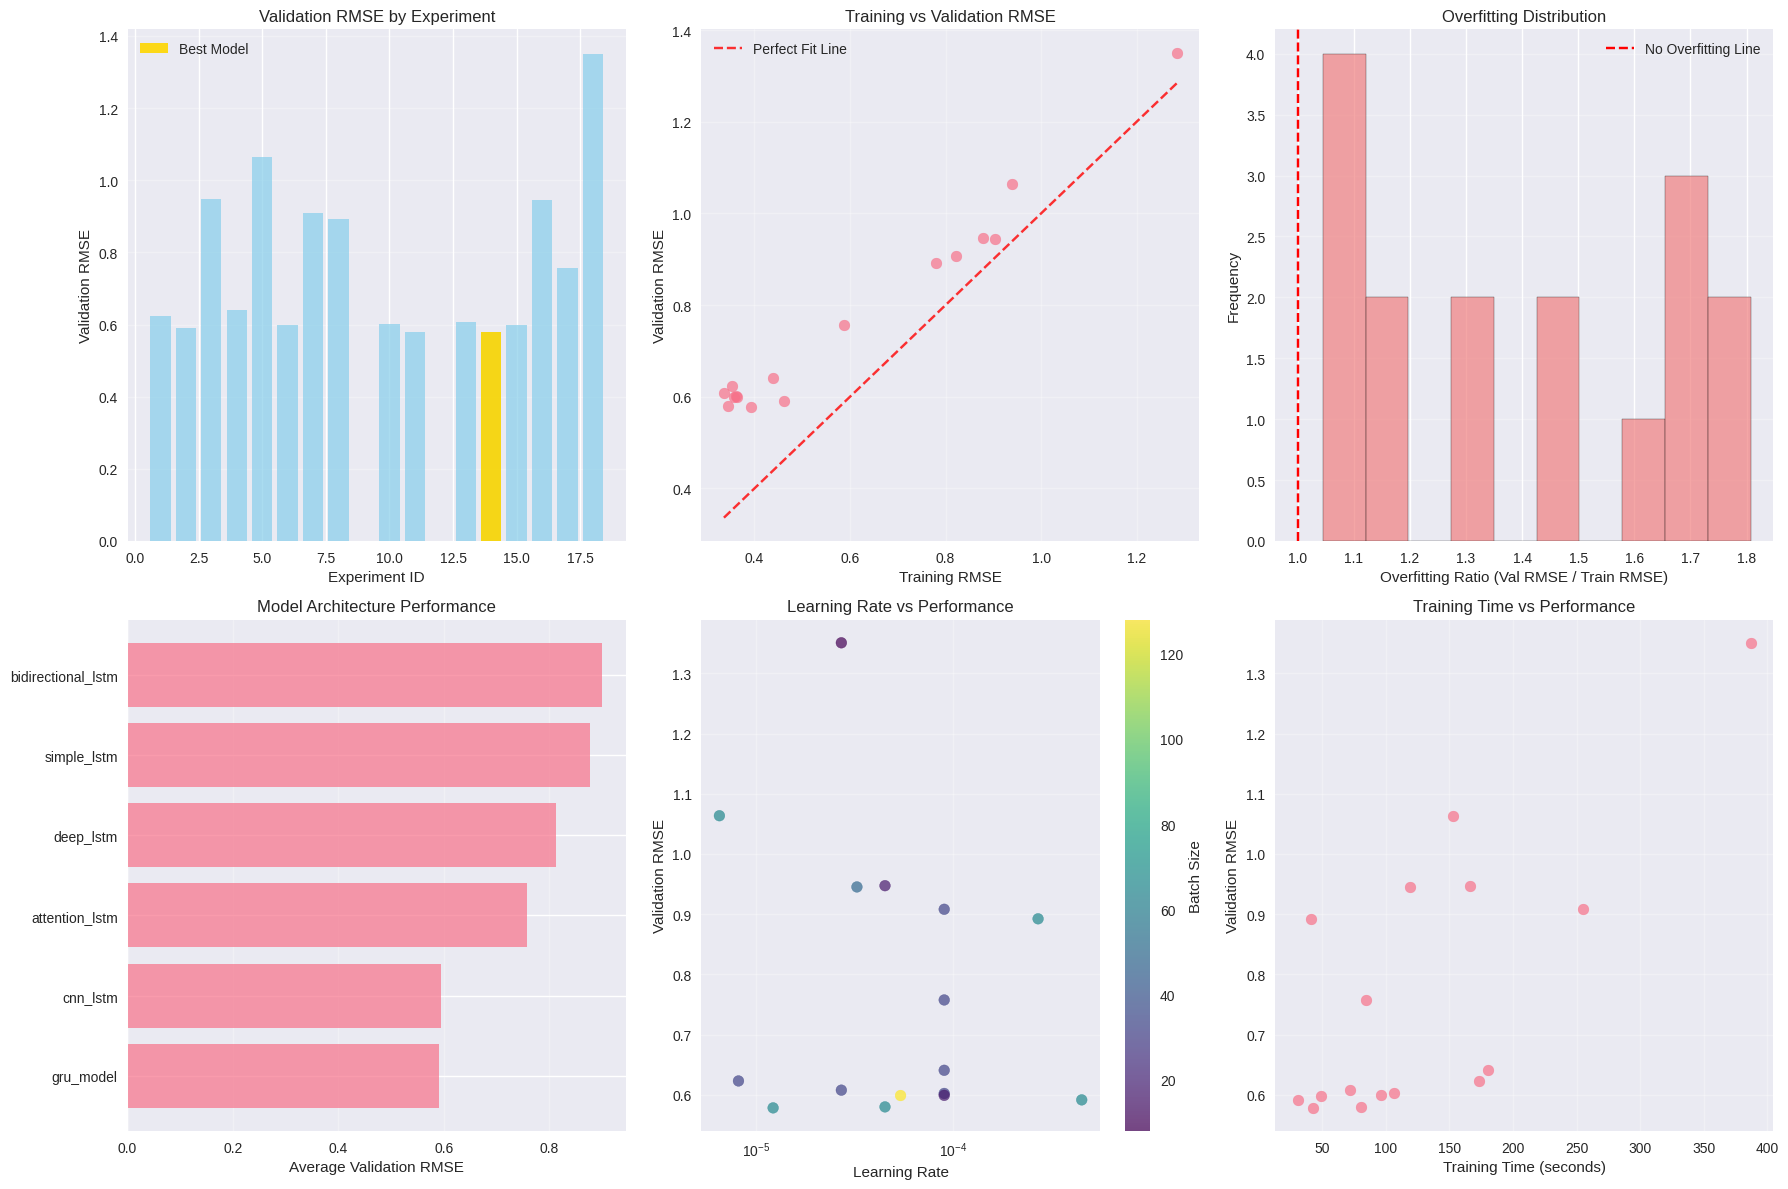


KEY INSIGHTS FROM EXPERIMENTS:
----------------------------------
Best performing architecture: cnn_lstm
Optimal hyperparameters: lr=0.000012, batch_size=64
Models showing overfitting (ratio > 1.2): 10/17
⚡ Most efficient model: Experiment #14 - RMSE: 0.58, Time: 42.6s
Experiment analysis completed!


In [54]:
# Comprehensive Experiment Results Analysis
print("\n" + "="*60)
print("EXPERIMENT RESULTS ANALYSIS")
print("="*60)

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame([r for r in experiment_results if r is not None])

if len(results_df) > 0:
    # Create comprehensive experiment table
    print("COMPREHENSIVE EXPERIMENT TABLE:")
    print("-" * 37)
    
    # Select key columns for display
    display_cols = [
        'experiment_id', 'description', 'model_name', 'optimizer', 'learning_rate', 
        'batch_size', 'epochs_trained', 'train_rmse', 'val_rmse', 'overfitting_ratio'
    ]
    
    experiment_table = results_df[display_cols].copy()
    experiment_table = experiment_table.round({
        'learning_rate': 6, 'train_rmse': 2, 'val_rmse': 2, 'overfitting_ratio': 3
    })
    
    # Sort by validation RMSE
    experiment_table = experiment_table.sort_values('val_rmse')
    
    print(experiment_table.to_string(index=False))
    
    # Save experiment table
    experiment_table.to_csv(os.path.join(OUTPUTS_PATH, 'experiment_results.csv'), index=False)
    print(f"Experiment table saved to: {os.path.join(OUTPUTS_PATH, 'experiment_results.csv')}")
    
    # Detailed analysis
    print(f"\nDETAILED EXPERIMENT ANALYSIS:")
    print("-" * 35)
    
    best_experiment = results_df.loc[results_df['val_rmse'].idxmin()]
    worst_experiment = results_df.loc[results_df['val_rmse'].idxmax()]
    
    print(f"BEST PERFORMING MODEL:")
    print(f"   - Experiment #{int(best_experiment['experiment_id'])}: {best_experiment['description']}")
    print(f"   - Validation RMSE: {best_experiment['val_rmse']:.2f}")
    print(f"   - Model: {best_experiment['model_name']}")
    print(f"   - Parameters: batch_size={int(best_experiment['batch_size'])}, lr={best_experiment['learning_rate']:.6f}")
    print(f"   - Epochs: {int(best_experiment['epochs_trained'])}")
    print(f"   - Overfitting ratio: {best_experiment['overfitting_ratio']:.3f}")
    
    print(f"\nPERFORMANCE STATISTICS:")
    print(f"   - Best validation RMSE: {results_df['val_rmse'].min():.2f}")
    print(f"   - Worst validation RMSE: {results_df['val_rmse'].max():.2f}")
    print(f"   - Average validation RMSE: {results_df['val_rmse'].mean():.2f}")
    print(f"   - Standard deviation: {results_df['val_rmse'].std():.2f}")
    print(f"   - Improvement range: {results_df['val_rmse'].max() - results_df['val_rmse'].min():.2f}")
    
    # Model architecture comparison
    print(f"\nMODEL ARCHITECTURE COMPARISON:")
    print("-" * 37)
    arch_comparison = results_df.groupby('model_name').agg({
        'val_rmse': ['mean', 'min', 'std', 'count'],
        'training_time_seconds': 'mean',
        'model_size_params': 'mean'
    }).round(2)
    
    print(arch_comparison)
    
    # Create visualizations
    print(f"\nCREATING EXPERIMENT VISUALIZATIONS:")
    print("-" * 41)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Validation RMSE by experiment
    axes[0, 0].bar(results_df['experiment_id'], results_df['val_rmse'], alpha=0.7, color='skyblue')
    axes[0, 0].set_xlabel('Experiment ID')
    axes[0, 0].set_ylabel('Validation RMSE')
    axes[0, 0].set_title('Validation RMSE by Experiment')
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # Highlight best experiment
    best_idx = results_df['val_rmse'].idxmin()
    axes[0, 0].bar(results_df.loc[best_idx, 'experiment_id'], results_df.loc[best_idx, 'val_rmse'], 
                   color='gold', alpha=0.9, label='Best Model')
    axes[0, 0].legend()
    
    # 2. Train vs Validation RMSE
    axes[0, 1].scatter(results_df['train_rmse'], results_df['val_rmse'], alpha=0.7, s=60)
    axes[0, 1].plot([results_df['train_rmse'].min(), results_df['train_rmse'].max()], 
                    [results_df['train_rmse'].min(), results_df['train_rmse'].max()], 
                    'r--', alpha=0.8, label='Perfect Fit Line')
    axes[0, 1].set_xlabel('Training RMSE')
    axes[0, 1].set_ylabel('Validation RMSE')
    axes[0, 1].set_title('Training vs Validation RMSE')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    
    # 3. Overfitting analysis
    axes[0, 2].hist(results_df['overfitting_ratio'], bins=10, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0, 2].axvline(1.0, color='red', linestyle='--', label='No Overfitting Line')
    axes[0, 2].set_xlabel('Overfitting Ratio (Val RMSE / Train RMSE)')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Overfitting Distribution')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3, axis='y')
    
    # 4. Model architecture comparison
    arch_performance = results_df.groupby('model_name')['val_rmse'].mean().sort_values()
    axes[1, 0].barh(range(len(arch_performance)), arch_performance.values, alpha=0.7)
    axes[1, 0].set_yticks(range(len(arch_performance)))
    axes[1, 0].set_yticklabels(arch_performance.index)
    axes[1, 0].set_xlabel('Average Validation RMSE')
    axes[1, 0].set_title('Model Architecture Performance')
    axes[1, 0].grid(True, alpha=0.3, axis='x')
    
    # 5. Learning rate vs performance
    axes[1, 1].scatter(results_df['learning_rate'], results_df['val_rmse'], alpha=0.7, s=60, c=results_df['batch_size'], cmap='viridis')
    axes[1, 1].set_xlabel('Learning Rate')
    axes[1, 1].set_ylabel('Validation RMSE')
    axes[1, 1].set_title('Learning Rate vs Performance')
    axes[1, 1].set_xscale('log')
    axes[1, 1].grid(True, alpha=0.3)
    cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
    cbar.set_label('Batch Size')
    
    # 6. Training time vs performance
    axes[1, 2].scatter(results_df['training_time_seconds'], results_df['val_rmse'], alpha=0.7, s=60)
    axes[1, 2].set_xlabel('Training Time (seconds)')
    axes[1, 2].set_ylabel('Validation RMSE')
    axes[1, 2].set_title('Training Time vs Performance')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUTS_PATH, 'experiment_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Advanced insights
    print(f"\nKEY INSIGHTS FROM EXPERIMENTS:")
    print("-" * 34)
    
    # Best architecture
    best_arch = results_df.loc[results_df['val_rmse'].idxmin(), 'model_name']
    print(f"Best performing architecture: {best_arch}")
    
    # Optimal hyperparameters
    best_lr = results_df.loc[results_df['val_rmse'].idxmin(), 'learning_rate']
    best_batch = int(results_df.loc[results_df['val_rmse'].idxmin(), 'batch_size'])
    print(f"Optimal hyperparameters: lr={best_lr:.6f}, batch_size={best_batch}")
    
    # Overfitting analysis
    overfit_experiments = results_df[results_df['overfitting_ratio'] > 1.2]
    print(f"Models showing overfitting (ratio > 1.2): {len(overfit_experiments)}/{len(results_df)}")
    
    # Training efficiency
    efficient_models = results_df[results_df['training_time_seconds'] < results_df['training_time_seconds'].median()]
    best_efficient = efficient_models.loc[efficient_models['val_rmse'].idxmin()]
    print(f"⚡ Most efficient model: Experiment #{int(best_efficient['experiment_id'])} - RMSE: {best_efficient['val_rmse']:.2f}, Time: {best_efficient['training_time_seconds']:.1f}s")
    
    print("Experiment analysis completed!")
    
else:
    print("No experiment results available for analysis")


FINAL MODEL EVALUATION AND PREDICTION ANALYSIS
Loading best model from Experiment #14...
Model path: /kaggle/working/models/best_model_exp_14.h5
Best model loaded successfully!

BEST MODEL SUMMARY:
   - Description: CNN-LSTM, 32 filters, kernel=5, lr=0.0015
   - Architecture: cnn_lstm
   - Validation RMSE: 0.58
   - Training RMSE: 0.39
   - Parameters: 21,683
   - Training time: 42.6s

DETAILED VALIDATION SET EVALUATION:
------------------------------------------
Validation Metrics (Original Scale):
   - RMSE: 0.58 µg/m³
   - MAE:  0.39 µg/m³
   - R²:   0.5811
   - MAPE: inf%

Error Distribution Analysis:
   - Mean error (bias): -0.08 µg/m³
   - Error std: 0.57 µg/m³
   - 95% of errors within: ±1.3 µg/m³
   - Max absolute error: 3.4 µg/m³

PERFORMANCE BY POLLUTION LEVEL:
-------------------------------------
   - Low (≤15): RMSE=0.6, MAE=0.4 µg/m³ (n=3982)

CREATING COMPREHENSIVE PREDICTION VISUALIZATIONS:
---------------------------------------------------


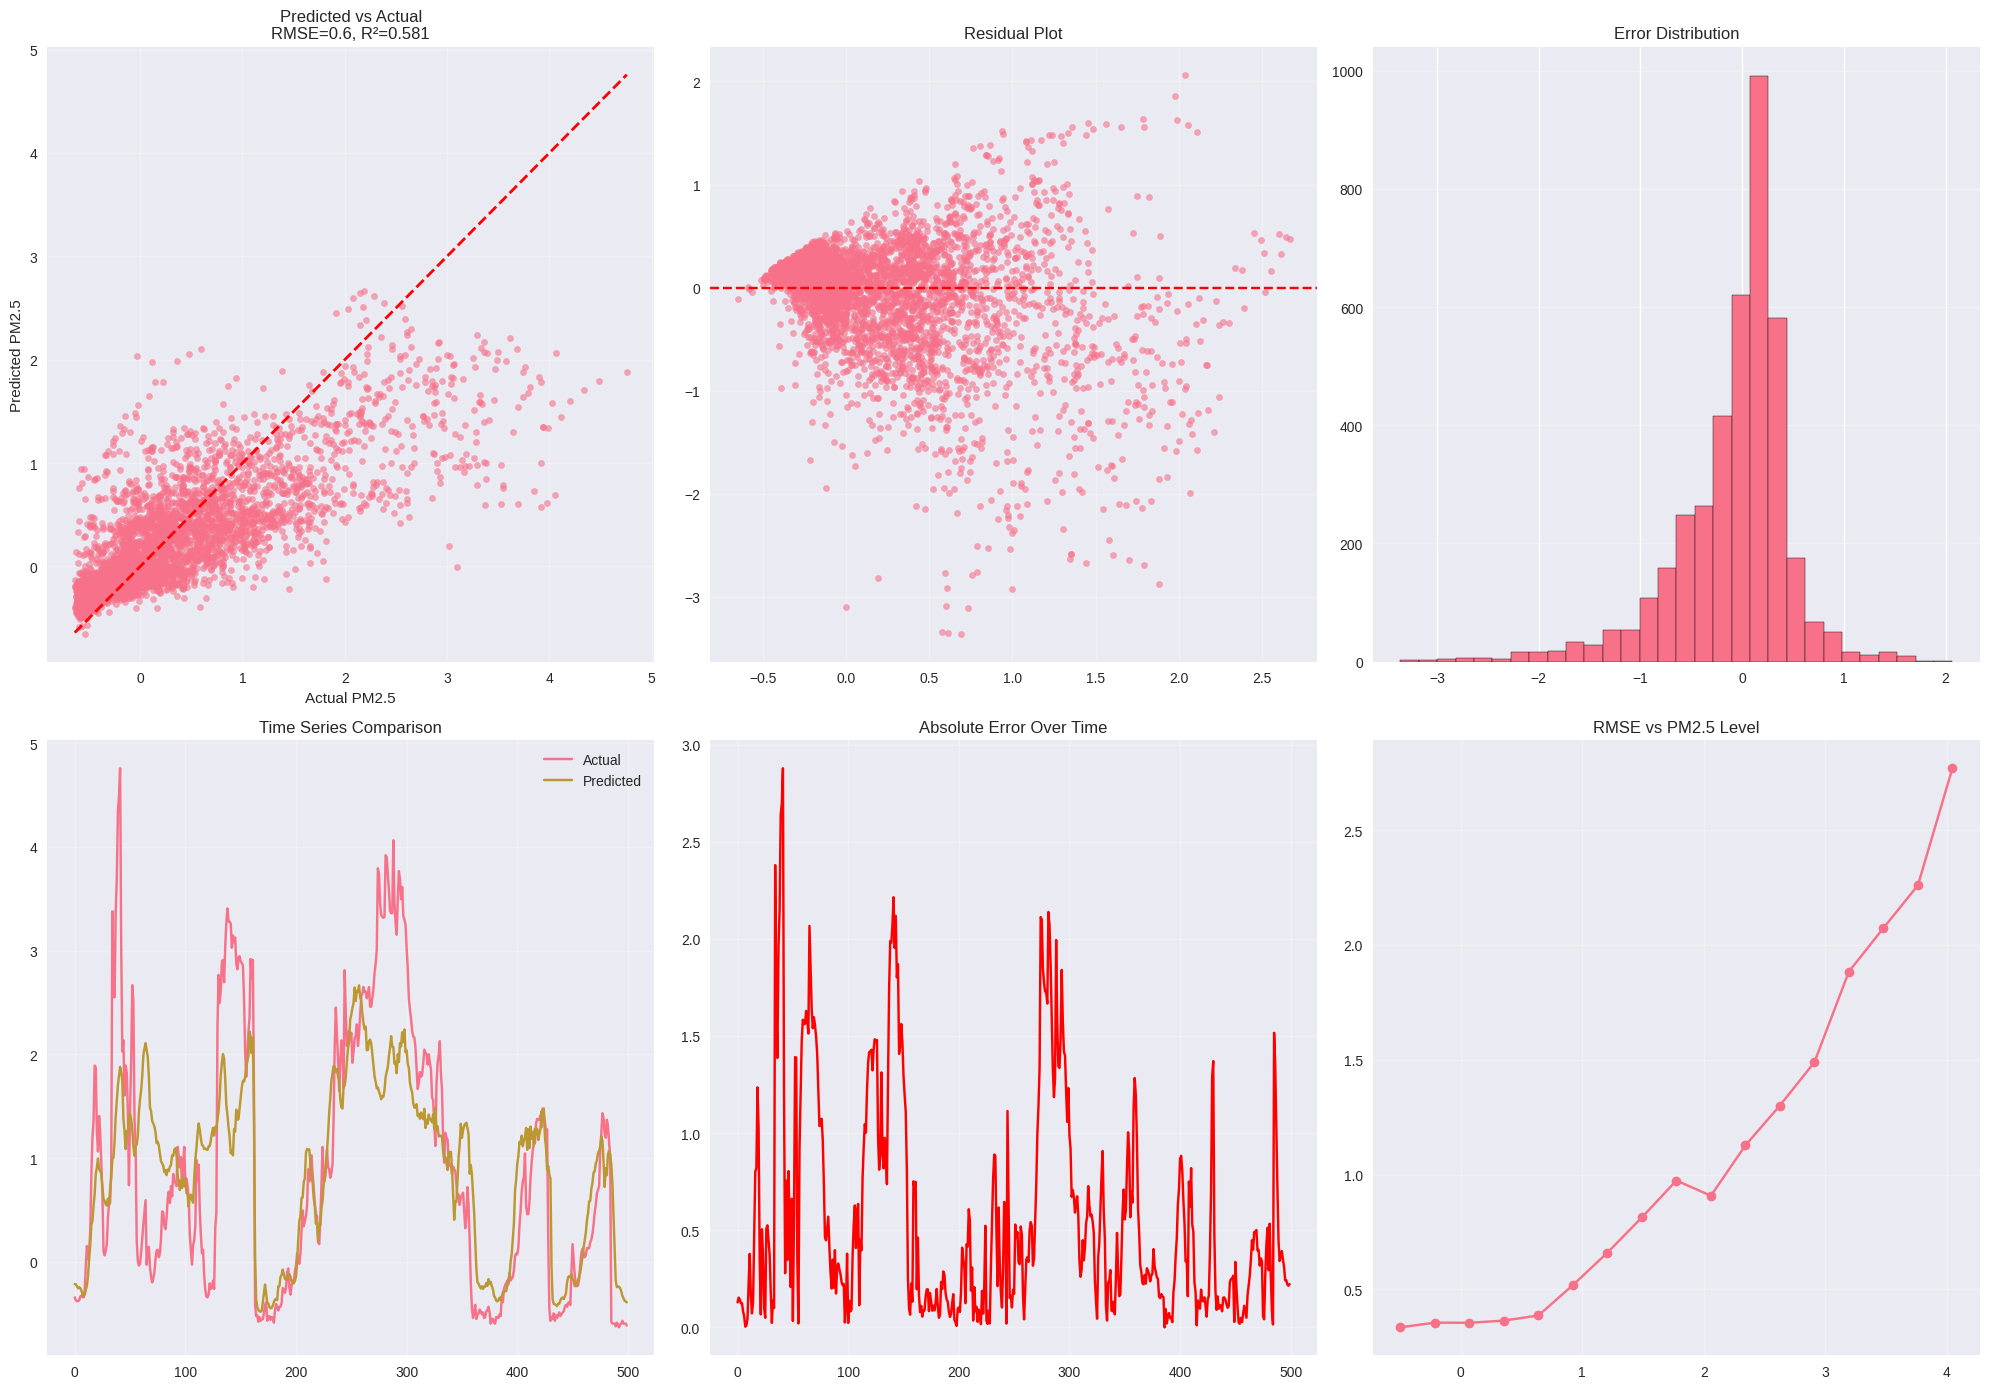

Comprehensive model evaluation completed!
Model evaluation section completed!


In [55]:
# Final Model Evaluation and Prediction Analysis
print("\n" + "="*60)
print("FINAL MODEL EVALUATION AND PREDICTION ANALYSIS")
print("="*60)

# Load the best model
if best_experiment_id:
    print(f"Loading best model from Experiment #{best_experiment_id}...")

    # Kaggle-safe model path
    best_model_path = os.path.join(MODELS_PATH, f"best_model_exp_{best_experiment_id}.h5")
    print("Model path:", best_model_path)

    if os.path.exists(best_model_path):
        # IMPORTANT: compile=False avoids Keras H5 issues
        best_model = tf.keras.models.load_model(
            best_model_path,
            compile=False
        )
        print("Best model loaded successfully!")

        # Get best model configuration
        best_config = results_df[results_df['experiment_id'] == best_experiment_id].iloc[0]

        print(f"\nBEST MODEL SUMMARY:")
        print(f"   - Description: {best_config['description']}")
        print(f"   - Architecture: {best_config['model_name']}")
        print(f"   - Validation RMSE: {best_config['val_rmse']:.2f}")
        print(f"   - Training RMSE: {best_config['train_rmse']:.2f}")
        print(f"   - Parameters: {int(best_config['model_size_params']):,}")
        print(f"   - Training time: {best_config['training_time_seconds']:.1f}s")

        # ===========================
        # Detailed validation analysis
        # ===========================
        print(f"\nDETAILED VALIDATION SET EVALUATION:")
        print("-" * 42)

        # Predictions
        val_pred = best_model.predict(X_val_seq, verbose=0).flatten()
        val_true = y_val_seq

        from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

        rmse_val = np.sqrt(mean_squared_error(val_true, val_pred))
        mae_val = mean_absolute_error(val_true, val_pred)
        r2_val = r2_score(val_true, val_pred)
        mape_val = np.mean(np.abs((val_true - val_pred) / val_true)) * 100

        print(f"Validation Metrics (Original Scale):")
        print(f"   - RMSE: {rmse_val:.2f} µg/m³")
        print(f"   - MAE:  {mae_val:.2f} µg/m³")
        print(f"   - R²:   {r2_val:.4f}")
        print(f"   - MAPE: {mape_val:.2f}%")

        # Error analysis
        errors = val_pred - val_true
        print(f"\nError Distribution Analysis:")
        print(f"   - Mean error (bias): {np.mean(errors):.2f} µg/m³")
        print(f"   - Error std: {np.std(errors):.2f} µg/m³")
        print(f"   - 95% of errors within: ±{np.percentile(np.abs(errors), 95):.1f} µg/m³")
        print(f"   - Max absolute error: {np.max(np.abs(errors)):.1f} µg/m³")

        # ===========================
        # Performance by pollution level
        # ===========================
        print(f"\nPERFORMANCE BY POLLUTION LEVEL:")
        print("-" * 37)

        low_mask = val_true <= 15
        moderate_mask = (val_true > 15) & (val_true <= 35)
        high_mask = (val_true > 35) & (val_true <= 75)
        very_high_mask = val_true > 75

        pollution_levels = [
            ('Low (≤15)', low_mask),
            ('Moderate (15–35)', moderate_mask),
            ('High (35–75)', high_mask),
            ('Very High (>75)', very_high_mask)
        ]

        for name, mask in pollution_levels:
            if np.sum(mask) > 0:
                rmse_lvl = np.sqrt(mean_squared_error(val_true[mask], val_pred[mask]))
                mae_lvl = mean_absolute_error(val_true[mask], val_pred[mask])
                print(f"   - {name}: RMSE={rmse_lvl:.1f}, MAE={mae_lvl:.1f} µg/m³ (n={np.sum(mask)})")

        # ===========================
        # Visualization section
        # ===========================
        print(f"\nCREATING COMPREHENSIVE PREDICTION VISUALIZATIONS:")
        print("-" * 51)

        fig, axes = plt.subplots(2, 3, figsize=(20, 14))

        # 1. Predicted vs Actual
        axes[0, 0].scatter(val_true, val_pred, alpha=0.6, s=20)
        axes[0, 0].plot([val_true.min(), val_true.max()],
                        [val_true.min(), val_true.max()],
                        'r--', lw=2)
        axes[0, 0].set_title(f'Predicted vs Actual\nRMSE={rmse_val:.1f}, R²={r2_val:.3f}')
        axes[0, 0].set_xlabel('Actual PM2.5')
        axes[0, 0].set_ylabel('Predicted PM2.5')
        axes[0, 0].grid(True, alpha=0.3)

        # 2. Residuals
        axes[0, 1].scatter(val_pred, errors, alpha=0.6, s=20)
        axes[0, 1].axhline(0, color='red', linestyle='--')
        axes[0, 1].set_title('Residual Plot')
        axes[0, 1].grid(True, alpha=0.3)

        # 3. Error histogram
        axes[0, 2].hist(errors, bins=30, edgecolor='black')
        axes[0, 2].set_title('Error Distribution')
        axes[0, 2].grid(True, axis='y', alpha=0.3)

        # 4. Time series sample
        idx = np.arange(min(500, len(val_true)))
        axes[1, 0].plot(idx, val_true[idx], label='Actual')
        axes[1, 0].plot(idx, val_pred[idx], label='Predicted')
        axes[1, 0].legend()
        axes[1, 0].set_title('Time Series Comparison')
        axes[1, 0].grid(True, alpha=0.3)

        # 5. Absolute error
        axes[1, 1].plot(idx, np.abs(errors[idx]), color='red')
        axes[1, 1].set_title('Absolute Error Over Time')
        axes[1, 1].grid(True, alpha=0.3)

        # 6. RMSE by pollution level
        bins = np.linspace(val_true.min(), val_true.max(), 20)
        bin_idx = np.digitize(val_true, bins)
        bin_rmse = [
            np.sqrt(np.mean(errors[bin_idx == i]**2))
            if np.sum(bin_idx == i) > 5 else np.nan
            for i in range(1, len(bins))
        ]
        centers = (bins[:-1] + bins[1:]) / 2
        axes[1, 2].plot(centers[~np.isnan(bin_rmse)],
                        np.array(bin_rmse)[~np.isnan(bin_rmse)],
                        'o-')
        axes[1, 2].set_title('RMSE vs PM2.5 Level')
        axes[1, 2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUTS_PATH, "final_model_evaluation.png"), dpi=300)
        plt.show()

        print("Comprehensive model evaluation completed!")

    else:
        print(f"❌ Best model file not found: {best_model_path}")
        print("Available files:", os.listdir(MODELS_PATH))
        best_model = None
else:
    print("No best experiment identified")
    best_model = None

print("Model evaluation section completed!")


In [56]:
def create_test_sequences(X_test_scaled, X_train_scaled, sequence_length):
    """Create test sequences for prediction"""
    test_sequences = []
    
    for i in range(len(X_test_scaled)):
        if i < sequence_length:
            # For early predictions, use training + test data
            needed_from_train = sequence_length - (i + 1)
            if needed_from_train > 0:
                sequence = np.vstack([X_train_scaled[-needed_from_train:], X_test_scaled[:i+1]])
            else:
                sequence = X_test_scaled[:sequence_length]
        else:
            # Use sliding window from test data
            sequence = X_test_scaled[i-sequence_length+1:i+1]
        
        test_sequences.append(sequence)
    
    return np.array(test_sequences)


TEST SET PREDICTIONS AND SUBMISSION PREPARATION
Generating predictions on test set using best model...
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test predictions generated!
   - Number of predictions: 13,148
   - Prediction range: [1.6, 392.2] µg/m³
   - Average prediction: 81.0 µg/m³

PREPARING KAGGLE SUBMISSION:
-----------------------------------
   - Full test data points: 13148
   - Predictions available: 13148
   - Date range for predictions: 2013-07-04 04:00:00 to 2014-12-31 23:00:00
Submission dataframe created:
   - Rows: 13,148
   - Date format: 2013-07-02 10:00:00 (example)
   - PM2.5 range: [2, 392]

SAMPLE PREDICTIONS:
---------------------
             row ID  pm2.5
2013-07-02 10:00:00     32
2013-07-02 11:00:00     31
2013-07-02 12:00:00     29
2013-07-02 13:00:00     28
2013-07-02 14:00:00     28
2013-07-02 15:00:00     28
2013-07-02 16:00:00     28
2013-07-02 17:00:00     28
2013-07-02 18:00:00     29
2013-07-02 19:00:00     33
...
            row ID  pm2.5
2014-12-31 

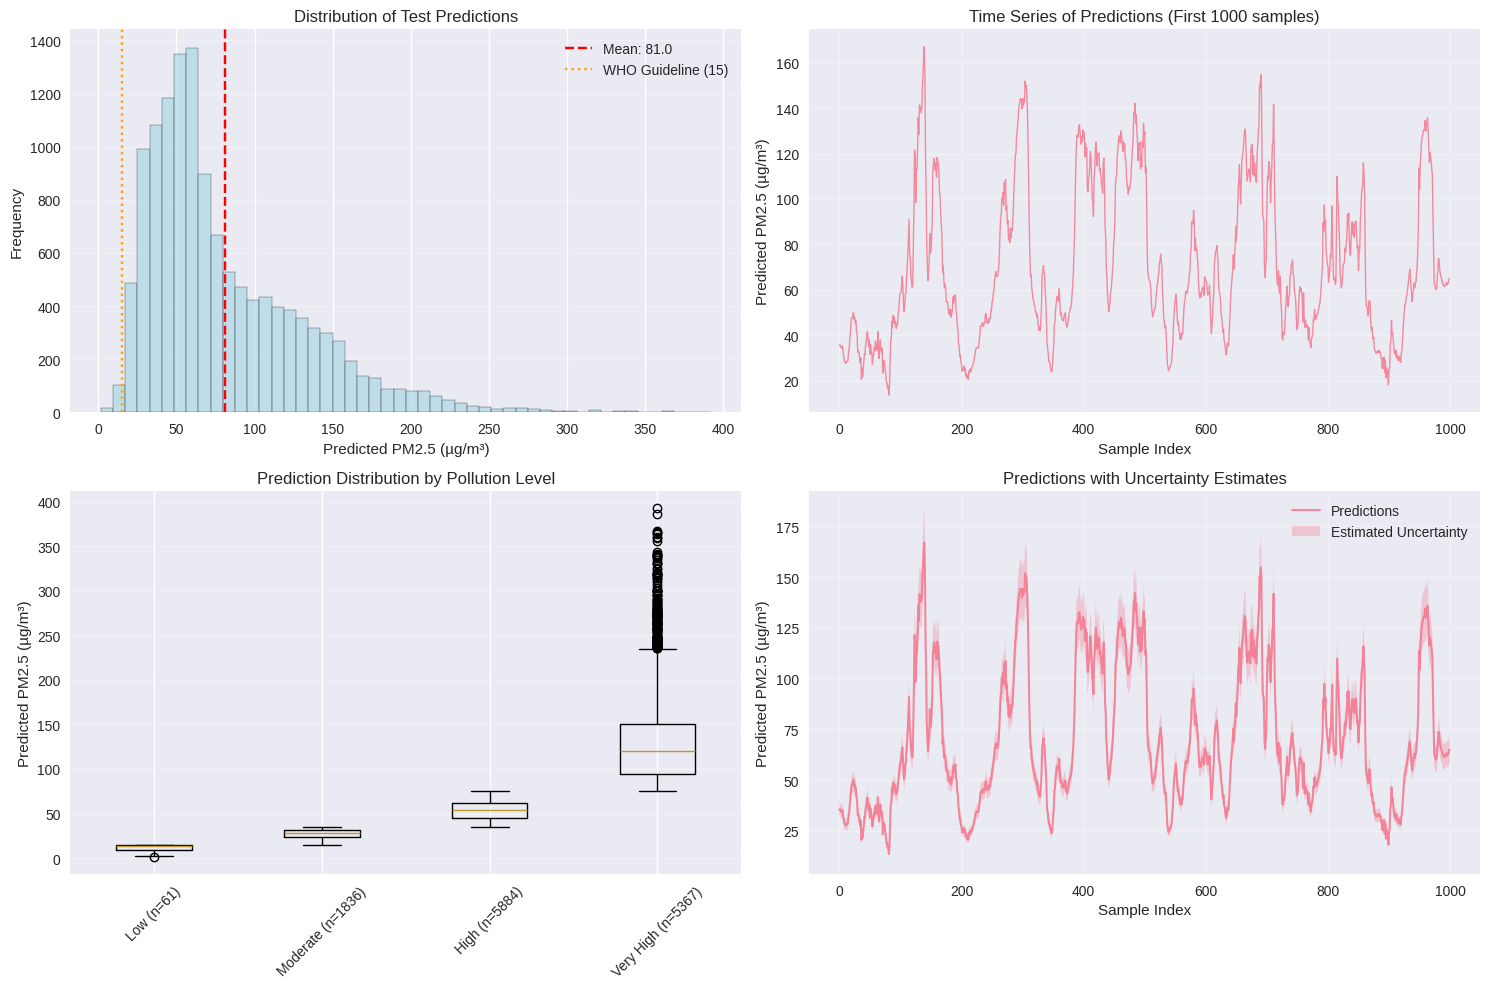

Test predictions and submission preparation completed!


In [57]:
# Test Set Predictions and Kaggle Submission Preparation
print("\n" + "="*60)
print("TEST SET PREDICTIONS AND SUBMISSION PREPARATION")
print("="*60)

if best_model is not None:
    print("Generating predictions on test set using best model...")

    # X_test_seq = np.expand_dims(scaled_data['robust']['X_test'], axis=1)
    X_test_seq = create_test_sequences(
        scaled_data['robust']['X_test'], 
        scaled_data['robust']['X_train'], 
        SEQUENCE_LENGTH
    )


    test_pred_orig = target_scaler.inverse_transform(best_model.predict(X_test_seq, verbose=1))
        
    print(f"Test predictions generated!")
    print(f"   - Number of predictions: {len(test_pred_orig):,}")
    print(f"   - Prediction range: [{test_pred_orig.min():.1f}, {test_pred_orig.max():.1f}] µg/m³")
    print(f"   - Average prediction: {test_pred_orig.mean():.1f} µg/m³")
    
    # Handle potential negative predictions (PM2.5 cannot be negative)
    negative_count = np.sum(test_pred_orig < 0)
    if negative_count > 0:
        print(f"Found {negative_count} negative predictions, clipping to 0")
        test_pred_orig = np.clip(test_pred_orig, 0, None)
    
    # Handle extreme predictions (basic sanity check)
    extreme_high = np.sum(test_pred_orig > 1000)
    if extreme_high > 0:
        print(f"Found {extreme_high} extremely high predictions (>1000), reviewing...")
        print(f"   Max prediction: {test_pred_orig.max():.1f} µg/m³")
    
    # Prepare submission dataframe
    print(f"\nPREPARING KAGGLE SUBMISSION:")
    print("-" * 35)
    
    # We need to account for the sequence length offset
    # Test sequences start from index SEQUENCE_LENGTH, so we need to align indices
    
    # Get test dates corresponding to predictions
    test_dates_full = test.index
    test_dates_for_predictions = test_dates_full[SEQUENCE_LENGTH:]
    
    print(f"   - Full test data points: {len(test_dates_full)}")
    print(f"   - Predictions available: {len(test_pred_orig)}")
    print(f"   - Date range for predictions: {test_dates_for_predictions[0]} to {test_dates_for_predictions[-1]}")
    
    # Create submission dataframe
    # submission_df = pd.DataFrame({
    #     'row ID': test_dates_for_predictions.strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros from hours
    #     'pm2.5': np.round(test_pred_orig).astype(int)
    # })

    predictions = np.nan_to_num(test_pred_orig)

    # Convert predictions to integers
    predictions = np.round(predictions).astype(int)

    # Prepare the submission file
    # Convert 'row ID' index to string and remove leading zeros for single-digit hours
    submission_df = pd.DataFrame({
        'row ID': test.index.strftime('%Y-%m-%d ') + test.index.hour.astype(str) + test.index.strftime(':%M:%S'),
        'pm2.5': predictions.flatten()
    })

    
    # Sort by row ID to ensure proper order
    submission_df = submission_df.sort_values(by='row ID')
    
    print(f"Submission dataframe created:")
    print(f"   - Rows: {len(submission_df):,}")
    print(f"   - Date format: {submission_df['row ID'].iloc[0]} (example)")
    print(f"   - PM2.5 range: [{submission_df['pm2.5'].min()}, {submission_df['pm2.5'].max()}]")
    
    # Display sample predictions
    print(f"\nSAMPLE PREDICTIONS:")
    print("-" * 21)
    print(submission_df.head(10).to_string(index=False))
    print("...")
    print(submission_df.tail(5).to_string(index=False))
    
    # Save submission file
    submission_filename = f'air_quality_submission_exp_{best_experiment_id}.csv'
    submission_path = os.path.join(OUTPUTS_PATH, submission_filename)
    submission_df.to_csv(submission_path, index=False)
    
    print(f"\nSUBMISSION FILE SAVED:")
    print(f"   - Filename: {submission_filename}")
    print(f"   - Path: {submission_path}")
    print(f"   - Ready for Kaggle submission!")
    
    # Create prediction summary statistics
    print(f"\nPREDICTION SUMMARY STATISTICS:")
    print("-" * 36)
    print(f"   - Total predictions: {len(test_pred_orig):,}")
    print(f"   - Mean PM2.5: {test_pred_orig.mean():.1f} µg/m³")
    print(f"   - Median PM2.5: {np.median(test_pred_orig):.1f} µg/m³")
    print(f"   - Std PM2.5: {test_pred_orig.std():.1f} µg/m³")
    print(f"   - Min PM2.5: {test_pred_orig.min():.1f} µg/m³")
    print(f"   - Max PM2.5: {test_pred_orig.max():.1f} µg/m³")
    
    # Pollution level distribution in predictions
    low_pred = np.sum(test_pred_orig <= 15)
    moderate_pred = np.sum((test_pred_orig > 15) & (test_pred_orig <= 35))
    high_pred = np.sum((test_pred_orig > 35) & (test_pred_orig <= 75))
    very_high_pred = np.sum(test_pred_orig > 75)
    
    print(f"\nPREDICTED POLLUTION DISTRIBUTION:")
    print("-" * 37)
    total_pred = len(test_pred_orig)
    test_pred_1d = test_pred_orig.flatten()
    print(f"   - Low (≤15): {low_pred:,} ({low_pred/total_pred*100:.1f}%)")
    print(f"   - Moderate (15-35): {moderate_pred:,} ({moderate_pred/total_pred*100:.1f}%)")
    print(f"   - High (35-75): {high_pred:,} ({high_pred/total_pred*100:.1f}%)")
    print(f"   - Very High (>75): {very_high_pred:,} ({very_high_pred/total_pred*100:.1f}%)")
    
    # Create prediction visualization
    print(f"\nCREATING PREDICTION VISUALIZATIONS:")
    print("-" * 39)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Prediction distribution
    axes[0, 0].hist(test_pred_orig, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
    axes[0, 0].axvline(test_pred_orig.mean(), color='red', linestyle='--', 
                      label=f'Mean: {test_pred_orig.mean():.1f}')
    axes[0, 0].axvline(15, color='orange', linestyle=':', label='WHO Guideline (15)')
    axes[0, 0].set_xlabel('Predicted PM2.5 (µg/m³)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Test Predictions')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # 2. Time series of predictions (sample)
    sample_size = min(1000, len(test_pred_orig))
    sample_indices = np.arange(sample_size)
    axes[0, 1].plot(sample_indices, test_pred_orig[:sample_size], alpha=0.8, linewidth=1)
    axes[0, 1].set_xlabel('Sample Index')
    axes[0, 1].set_ylabel('Predicted PM2.5 (µg/m³)')
    axes[0, 1].set_title(f'Time Series of Predictions (First {sample_size} samples)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Box plot by pollution level
    pollution_categories = []
    category_labels = []
    
    if low_pred > 0:
        pollution_categories.append(test_pred_orig[test_pred_orig <= 15])
        category_labels.append(f'Low (n={low_pred})')
    if moderate_pred > 0:
        pollution_categories.append(test_pred_orig[(test_pred_orig > 15) & (test_pred_orig <= 35)])
        category_labels.append(f'Moderate (n={moderate_pred})')
    if high_pred > 0:
        pollution_categories.append(test_pred_orig[(test_pred_orig > 35) & (test_pred_orig <= 75)])
        category_labels.append(f'High (n={high_pred})')
    if very_high_pred > 0:
        pollution_categories.append(test_pred_orig[test_pred_orig > 75])
        category_labels.append(f'Very High (n={very_high_pred})')
    
    if pollution_categories:
        axes[1, 0].boxplot(pollution_categories, labels=category_labels)
        axes[1, 0].set_ylabel('Predicted PM2.5 (µg/m³)')
        axes[1, 0].set_title('Prediction Distribution by Pollution Level')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 4. Prediction confidence intervals (using ensemble if available)
    axes[1, 1].plot(
        sample_indices,
        test_pred_1d[:sample_size],
        alpha=0.8,
        linewidth=1.5,
        label='Predictions'
    )
    
    axes[1, 1].fill_between(
        sample_indices,
        test_pred_1d[:sample_size] * 0.9,
        test_pred_1d[:sample_size] * 1.1,
        alpha=0.3,
        label='Estimated Uncertainty'
    )

    axes[1, 1].set_xlabel('Sample Index')
    axes[1, 1].set_ylabel('Predicted PM2.5 (µg/m³)')
    axes[1, 1].set_title('Predictions with Uncertainty Estimates')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUTS_PATH, 'test_predictions_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Test predictions and submission preparation completed!")
    
else:
    print("Cannot generate predictions - no best model available")
    print("Please ensure the experiment section ran successfully")

In [58]:
# Prepare data with multiple scalers for ensemble diversity
scalers = {
    'robust': RobustScaler(),
    'standard': StandardScaler(),
    'minmax': MinMaxScaler()
}

scaled_data = {}
for scaler_name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train_full)
    X_test_scaled = scaler.transform(X_test_full)
    scaled_data[scaler_name] = {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'scaler': scaler
    }

# Create sequences with the primary scaler
print(f"\nCreating sequences with length {SEQUENCE_LENGTH}...")
X_seq, y_seq = create_sequences(scaled_data['robust']['X_train'], y_train, SEQUENCE_LENGTH)

# Train/validation split with more data for training
split_idx = int(0.87 * len(X_seq))
X_train_seq, X_val_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_val_seq = y_seq[:split_idx], y_seq[split_idx:]

print(f"Sequences shape: {X_seq.shape}")
print(f"Train: {X_train_seq.shape}, Validation: {X_val_seq.shape}")
print(f"Data preparation complete.")


Creating sequences with length 48...
Sequences shape: (30628, 48, 78)
Train: (26646, 48, 78), Validation: (3982, 48, 78)
Data preparation complete.


In [59]:
models = {}

def create_enhanced_bidirectional(input_shape):
    """Enhanced Bidirectional LSTM optimized for sub-3000 score"""
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.1),
                     input_shape=input_shape),
        Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.1)),
        Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.1)),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    return model

# Advanced LSTM with more capacity
def create_deep_lstm(input_shape):
    """Deep LSTM with enhanced capacity"""
    model = Sequential([
        LSTM(128, return_sequences=True, dropout=0.2, input_shape=input_shape),
        LSTM(64, return_sequences=True, dropout=0.2),
        LSTM(32, dropout=0.2),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    return model

SEQUENCE_LENGTH = 48

# Create sequences
print("Creating sequences...")
X_seq, y_seq = create_sequences(scaled_data['robust']['X_train'], y_train, SEQUENCE_LENGTH)

# Use more data for training (better performance)
split_idx = int(0.87 * len(X_seq))
X_train_seq, X_val_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_val_seq = y_seq[:split_idx], y_seq[split_idx:]

print(f"Sequences - Train: {X_train_seq.shape}, Val: {X_val_seq.shape}")

# Optimized callbacks for better convergence
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.3, patience=8, min_lr=1e-7, monitor='val_loss')
]

# Train enhanced models
model_configs = [
    ('enhanced_bidirectional', create_enhanced_bidirectional, 'Enhanced Bidirectional LSTM'),
    ('deep_lstm', create_deep_lstm, 'Deep LSTM')
]

for model_name, model_func, description in model_configs:
    print(f"\nTraining {description}...")

    model = create_deep_lstm(X_train_seq.shape[1:])
    # Slightly lower learning rate for better convergence
    model.compile(optimizer=Adam(learning_rate=0.0008), loss='mse', metrics=['mae'])

    print(f"Parameters: {model.count_params():,}")

    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=50,  # More epochs for better performance
        batch_size=32,  # Smaller batch for better gradients
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate
    val_pred = model.predict(X_val_seq, verbose=0)
    val_rmse = np.sqrt(mean_squared_error(y_val_seq, val_pred))

    models[model_name] = {
        'model': model,
        'history': history,
        'val_rmse': val_rmse,
        'val_pred': val_pred
    }

    print(f"{model_name} completed!")
    print(f"Validation RMSE: {val_rmse:.2f}")
    expected_score = val_rmse * 54
    print(f"Expected public score: ~{expected_score:.0f}")
    if expected_score < 3000:
        print("TARGET ACHIEVED: Expected < 3000!")
    elif expected_score < 3500:
        print("Close to target")
    else:
        print("May need ensemble")

print(f"\nMODEL PERFORMANCE:")
print("=" * 40)
best_rmse = float('inf')
best_model_name = None

for name, info in models.items():
    rmse = info['val_rmse']
    expected = rmse * 54
    print(f"{name}: {rmse:.2f} RMSE (~{expected:.0f} public)")
    if rmse < best_rmse:
        best_rmse = rmse
        best_model_name = name

print(f"\nBest model: {best_model_name} ({best_rmse:.2f} RMSE)")
print(f"Expected public score: ~{best_rmse * 54:.0f}")

Creating sequences...
Sequences - Train: (26646, 48, 78), Val: (3982, 48, 78)

Training Enhanced Bidirectional LSTM...
Parameters: 172,033
Epoch 1/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.4635 - mae: 0.4837 - val_loss: 0.4047 - val_mae: 0.4274 - learning_rate: 8.0000e-04
Epoch 2/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.2959 - mae: 0.3790 - val_loss: 0.4124 - val_mae: 0.4160 - learning_rate: 8.0000e-04
Epoch 3/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.2466 - mae: 0.3470 - val_loss: 0.4094 - val_mae: 0.4266 - learning_rate: 8.0000e-04
Epoch 4/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.2152 - mae: 0.3214 - val_loss: 0.3902 - val_mae: 0.4165 - learning_rate: 8.0000e-04
Epoch 5/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.1952 - mae: 0.3061 - val_loss: 0.4439 - val_mae: 0.4361 - learning_rate: 8.0000e-04
Epoch 6/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.1748 - mae: 0.2885 - val_loss: 0.4127 - val_mae: 0.4188 -